<center>
КОНКУРСНАЯ ЗАДАЧА TINKOFF DATA SCIENCE CHALLENGE:
<center>   
Необходимо предсказать, откроет ли клиент кредитный счет  или нет.

In [278]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib notebook
import seaborn as sns

import chardet
from bs4 import UnicodeDammit

from scipy.stats import kruskal
from scipy.stats import shapiro
from scipy.stats import norm
from scipy.stats import probplot
from scipy.stats import boxcox

import statsmodels.api as sm
import random

from tqdm.auto import tqdm
import re

In [2]:
RND_STATE = 777
random.seed(RND_STATE)

# Считывание данных в формате .csv в DataFrame

In [3]:
data_encodings = []

with open("Data\credit_train.csv", 'rb') as f:
    rawdata = b''.join([f.readline() for _ in range(1000)])
    data_encodings.append(chardet.detect(rawdata)['encoding'])
    data_encodings.append(UnicodeDammit(rawdata).original_encoding)
       
print(f"Кодировка исходного файла: {data_encodings}")

Кодировка исходного файла: ['KOI8-R', 'koi8-r']


Однако, кодировка KOI8-R не подходит для корректного открытия файла, поэтому было решено проверить наиболее распространенные кодировки для файлов, содержащих кириллицу.

In [4]:
data_encodings.extend(['utf-16','CP866', 'Windows-1251', 'utf-8', 'cp1251'])

In [5]:
file_encoding = ''
for encoding in data_encodings:
    try:
        with pd.read_csv("Data\credit_train.csv", encoding=encoding, sep=";", index_col='client_id', iterator=True) as reader:
            print('--------------------------------')
            print(f'Кодировка: {encoding}')
            print(reader.get_chunk(5))
            print('--------------------------------\n')
        if input("Если кодировка верна, введи 'верно' >>>>  ") == 'верно':
            file_encoding = encoding
            break
    except UnicodeDecodeError:
        print(f'Кодировка: {encoding} не подходит!')

--------------------------------
Кодировка: KOI8-R
          gender   age marital_status job_position credit_sum  credit_month  \
client_id                                                                     
1              M   NaN            NaN          UMN   59998,00            10   
2              F   NaN            MAR          UMN   10889,00             6   
3              M  32.0            MAR          SPC   10728,00            12   
4              F  27.0            NaN          SPC   12009,09            12   
5              M  45.0            NaN          SPC        NaN            10   

           tariff_id score_shk education        living_region  monthly_income  \
client_id                                                                       
1                1.6       NaN       GRD   йпюямндюпяйхи йпюи         30000.0   
2                1.1       NaN       NaN               лняйбю             NaN   
3                1.1       NaN       NaN      нак яюпюрнбяйюъ          

In [6]:
init_data = pd.read_csv("Data\credit_train.csv", encoding=file_encoding, sep=";")
init_data.head(5)

,client_id,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,monthly_income,credit_count,overdue_credit_count,open_account_flg
0,1,M,NaN,NaN,UMN,"59998,00",10,1.6,NaN,GRD,КРАСНОДАРСКИЙ КРАЙ,30000.0,1.0,1.0,0
1,2,F,NaN,MAR,UMN,"10889,00",6,1.1,NaN,NaN,МОСКВА,NaN,2.0,0.0,0
2,3,M,32.0,MAR,SPC,"10728,00",12,1.1,NaN,NaN,ОБЛ САРАТОВСКАЯ,NaN,5.0,0.0,0
3,4,F,27.0,NaN,SPC,"12009,09",12,1.1,NaN,NaN,ОБЛ ВОЛГОГРАДСКАЯ,NaN,2.0,0.0,0
4,5,M,45.0,NaN,SPC,NaN,10,1.1,"0,421385",SCH,ЧЕЛЯБИНСКАЯ ОБЛАСТЬ,NaN,1.0,0.0,0


In [7]:
print(f'Число наблюдений - {init_data.shape[0]}')
print(f'Число фичей (переменных) - {init_data.shape[1]}')

Число наблюдений - 170746
Число фичей (переменных) - 15


# Предварительная подготовка данных

**Список переменных:**

* `client_id` - Идентификационный номер клиента

* `gender` - Пол

* `age` - Возраст

* `marital_status` - Семейный статус

* `job_position` - Сфера занятости

* `credit_sum` - Сумма кредита

* `credit_month` - Срок кредитования

* `tariff_id` - Идентификационный номер тарифа

* `score_shk` - Внутренняя скоринговая оценка

* `education` - Образование

* `living_region` - Регион проживания

* `monthly_income` - Месячный заработок

* `credit_count` - Количество кредитов у клиента

* `overdue_credit_count` - Количество просроченных кредитов у клиента

* `open_account_flg` - Факт открытия кредитного счета в данном банке (целевая переменная)

## Удаление очевидных бесполезных переменных

В данном случае имеются ввиду переменные, у которых количество категорий совпадает с количеством наблюдений, или, наоборот, переменные с одним уникальным значением.

In [8]:
init_data.nunique()

client_id               170746
gender                       2
age                         54
marital_status               5
job_position                18
credit_sum               42769
credit_month                31
tariff_id                   32
score_shk                16279
education                    5
living_region              301
monthly_income            1591
credit_count                21
overdue_credit_count         4
open_account_flg             2
dtype: int64

Откинем столбец `client_id` поскольку он совпадает с номером наблюдения и не несет никакой предсказательной способности.

In [9]:
init_data.drop('client_id', inplace=True, axis=1)

In [10]:
init_data.head(5)

,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,monthly_income,credit_count,overdue_credit_count,open_account_flg
0,M,NaN,NaN,UMN,"59998,00",10,1.6,NaN,GRD,КРАСНОДАРСКИЙ КРАЙ,30000.0,1.0,1.0,0
1,F,NaN,MAR,UMN,"10889,00",6,1.1,NaN,NaN,МОСКВА,NaN,2.0,0.0,0
2,M,32.0,MAR,SPC,"10728,00",12,1.1,NaN,NaN,ОБЛ САРАТОВСКАЯ,NaN,5.0,0.0,0
3,F,27.0,NaN,SPC,"12009,09",12,1.1,NaN,NaN,ОБЛ ВОЛГОГРАДСКАЯ,NaN,2.0,0.0,0
4,M,45.0,NaN,SPC,NaN,10,1.1,"0,421385",SCH,ЧЕЛЯБИНСКАЯ ОБЛАСТЬ,NaN,1.0,0.0,0


## Преобразование типов данных

В данном разделе подразумевается преобразование типов данных к корректным, например, `credit_sum` в датасете имеет тип `object`, чего не должно быть. Также, часто переменные-флаги, такие как "наличие оттока", "наличие дефолта" и т.п. записываются как целочисленные значения.

In [11]:
init_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170746 entries, 0 to 170745
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   gender                170746 non-null  object 
 1   age                   170743 non-null  float64
 2   marital_status        170743 non-null  object 
 3   job_position          170746 non-null  object 
 4   credit_sum            170744 non-null  object 
 5   credit_month          170746 non-null  int64  
 6   tariff_id             170746 non-null  float64
 7   score_shk             170739 non-null  object 
 8   education             170741 non-null  object 
 9   living_region         170554 non-null  object 
 10  monthly_income        170741 non-null  float64
 11  credit_count          161516 non-null  float64
 12  overdue_credit_count  161516 non-null  float64
 13  open_account_flg      170746 non-null  int64  
dtypes: float64(5), int64(2), object(7)
memory usage: 18.

In [12]:
for column in ['score_shk', 'credit_sum']:
    init_data[column] = init_data[column].str.replace(',', '.').astype('float')

In [13]:
for column in ['tariff_id', 'open_account_flg']:
    init_data[column] = init_data[column].astype('object')

In [14]:
init_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170746 entries, 0 to 170745
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   gender                170746 non-null  object 
 1   age                   170743 non-null  float64
 2   marital_status        170743 non-null  object 
 3   job_position          170746 non-null  object 
 4   credit_sum            170744 non-null  float64
 5   credit_month          170746 non-null  int64  
 6   tariff_id             170746 non-null  object 
 7   score_shk             170739 non-null  float64
 8   education             170741 non-null  object 
 9   living_region         170554 non-null  object 
 10  monthly_income        170741 non-null  float64
 11  credit_count          161516 non-null  float64
 12  overdue_credit_count  161516 non-null  float64
 13  open_account_flg      170746 non-null  object 
dtypes: float64(6), int64(1), object(7)
memory usage: 18.

In [15]:
init_data.head(5)

,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,monthly_income,credit_count,overdue_credit_count,open_account_flg
0,M,NaN,NaN,UMN,59998.00,10,1.6,NaN,GRD,КРАСНОДАРСКИЙ КРАЙ,30000.0,1.0,1.0,0
1,F,NaN,MAR,UMN,10889.00,6,1.1,NaN,NaN,МОСКВА,NaN,2.0,0.0,0
2,M,32.0,MAR,SPC,10728.00,12,1.1,NaN,NaN,ОБЛ САРАТОВСКАЯ,NaN,5.0,0.0,0
3,F,27.0,NaN,SPC,12009.09,12,1.1,NaN,NaN,ОБЛ ВОЛГОГРАДСКАЯ,NaN,2.0,0.0,0
4,M,45.0,NaN,SPC,NaN,10,1.1,0.421385,SCH,ЧЕЛЯБИНСКАЯ ОБЛАСТЬ,NaN,1.0,0.0,0


## Нормализация строковых значений

В данный этап обработки данных входит удаление лишних символов, приведение строк к одному и тому же регистру.
В исследуемом датасете необходимо обработать колонку `living_region`, поскольку уже по нескольким первым записям видно, что вид регионов не стандартизован.

In [16]:
init_data['living_region'].nunique()

301

In [17]:
pd.options.display.max_rows = 310

In [18]:
init_data['living_region'].value_counts(dropna=False).sort_index()

74                                              1
98                                              1
АДЫГЕЯ РЕСП                                     9
АЛТАЙСКИЙ                                       2
АЛТАЙСКИЙ КРАЙ                                  8
АМУРСКАЯ ОБЛ                                   12
АМУРСКАЯ ОБЛАСТЬ                               20
АО НЕНЕЦКИЙ                                    20
АО ХАНТЫ-МАНСИЙСКИЙ АВТОНОМНЫЙ ОКРУГ - Ю      559
АО ЯМАЛО-НЕНЕЦКИЙ                             141
АОБЛ ЕВРЕЙСКАЯ                                  4
АРХАНГЕЛЬСКАЯ                                   1
АРХАНГЕЛЬСКАЯ ОБЛ                              18
АРХАНГЕЛЬСКАЯ ОБЛАСТЬ                           9
АСТРАХАНСКАЯ                                   25
АСТРАХАНСКАЯ ОБЛ                               31
АСТРАХАНСКАЯ ОБЛАСТЬ                          143
БАШКОРТОСТАН                                   26
БАШКОРТОСТАН РЕСП                             133
БЕЛГОРОДСКАЯ ОБЛ                               29


In [19]:
region_unique = init_data['living_region'].unique()
regions = pd.Series(data=region_unique, index=region_unique, name='regions')

In [20]:
region_stopwords = ['ОБЛ','ОБЛАСТЬ', 'РЕСП', 'РЕСПУБЛИКА', 'КРАЙ', 'Г', 'АО', 'АОБЛ', 'АВТОНОМНАЯ']

In [21]:
def clean_region(region : str, stopwords : list) -> str:
    """
    Deletes stopwords in the region string gained from the stopword-list.
    Returns the remained words joined without spaces.
    
    Keyword arguments:
    region -- name string of the region
    stopwords -- the list of words to be deleted from the region name
    """
    words = re.sub('[,.]+', ' ', str(region)).split(' ')
    cleaned_name = ''
    for word in words:
        if word not in stopwords:
            cleaned_name += word
    return cleaned_name

In [22]:
regions_normalized = regions.apply(clean_region, args=(region_stopwords,))

In [23]:
regions_normalized['ЧУКОТСКИЙ АO'] = 'ЧУКОТСКИЙ'
regions_normalized['ЧУВАШСКАЯ РЕСПУБЛИКА - ЧУВАШИЯ'] = 'ЧУВАШСКАЯ'
regions_normalized['ЧУВАШИЯ ЧУВАШСКАЯ РЕСПУБЛИКА -'] = 'ЧУВАШСКАЯ'
regions_normalized['ЧУВАШСКАЯ - ЧУВАШИЯ РЕСП'] = 'ЧУВАШСКАЯ'
regions_normalized['РЕСП ЧУВАШСКАЯ - ЧУВАШИЯ'] = 'ЧУВАШСКАЯ'
regions_normalized['ЧУВАШСКАЯ - ЧУВАШИЯ РЕСП'] = 'ЧУВАШСКАЯ'
regions_normalized['РЕСПУБЛИКАТАТАРСТАН'] = 'ТАТАРСТАН'
regions_normalized['ПРИВОЛЖСКИЙ ФЕДЕРАЛЬНЫЙ ОКРУГ'] = 'МОСКОВСКАЯ'
regions_normalized['ПЕРМСКАЯ ОБЛ'] = 'ПЕРМСКИЙ'
regions_normalized['ОРЁЛ'] = 'ОРЛОВСКАЯ'
regions_normalized['Г.ОДИНЦОВО МОСКОВСКАЯ ОБЛ'] = 'МОСКОВСКАЯ'
regions_normalized['МЫТИЩИНСКИЙ Р-Н'] = 'МОСКОВСКАЯ'
regions_normalized['МОСКОВСКИЙ П'] = 'МОСКОВСКАЯ'
regions_normalized['КАМЧАТСКАЯ ОБЛАСТЬ'] = 'КАМЧАТСКИЙ'
regions_normalized['ДАЛЬНИЙ ВОСТОК'] = 'МОСКОВСКАЯ'
regions_normalized['ДАЛЬНИЙВОСТОК'] = 'МОСКОВСКАЯ'
regions_normalized['ГУСЬ-ХРУСТАЛЬНЫЙ Р-Н'] = 'ВЛАДИМИРСКАЯ'
regions_normalized['ГОРЬКОВСКАЯ ОБЛ'] = 'НИЖЕГОРОДСКАЯ'
regions_normalized['ЭВЕНКИЙСКИЙ АО'] = 'КРАСНОЯРСКИЙ'
regions_normalized['ХАНТЫ-МАНСИЙСКИЙ АВТОНОМНЫЙ ОКРУГ - ЮГРА'] = 'ХАНТЫ-МАНСИЙСКИЙ'
regions_normalized['АО ХАНТЫ-МАНСИЙСКИЙ АВТОНОМНЫЙ ОКРУГ - Ю'] = 'ХАНТЫ-МАНСИЙСКИЙ'
regions_normalized['АО ХАНТЫ-МАНСИЙСКИЙ-ЮГРА'] = 'ХАНТЫ-МАНСИЙСКИЙ'
regions_normalized['СЕВ. ОСЕТИЯ - АЛАНИЯ'] = 'СЕВЕРНАЯОСЕТИЯ-АЛАНИЯ'
regions_normalized['РЕСП. САХА (ЯКУТИЯ)'] ='САХА/ЯКУТИЯ/'
regions_normalized['РЕСПУБЛИКА САХА'] = 'САХА/ЯКУТИЯ/'
regions_normalized['ДАЛЬНИЙВОСТОК'] = 'МОСКОВСКАЯ'
regions_normalized['САХА'] = 'САХА/ЯКУТИЯ/'
regions_normalized['98'] = 'САНКТ-ПЕТЕРБУРГ'
regions_normalized['74'] = 'ЧЕЛЯБИНСКАЯ'
regions_normalized['РОССИЯ'] = 'МОСКОВСКАЯ'
regions_normalized['МОСКВОСКАЯ'] = 'МОСКОВСКАЯ'
regions_normalized['МОСКВОСКАЯ ОБЛ'] = 'МОСКОВСКАЯ'
regions_normalized['ЧЕЛЯБИНСК'] = 'ЧЕЛЯБИНСКАЯ'
regions_normalized['Г. ЧЕЛЯБИНСК'] = 'ЧЕЛЯБИНСКАЯ'
regions_normalized['БРЯНСКИЙ'] = 'БРЯНСКАЯ'
regions_normalized[np.NaN] = np.NaN

In [24]:
regions_normalized.sort_index()

74                                                    ЧЕЛЯБИНСКАЯ
98                                                САНКТ-ПЕТЕРБУРГ
АДЫГЕЯ РЕСП                                                АДЫГЕЯ
АЛТАЙСКИЙ                                               АЛТАЙСКИЙ
АЛТАЙСКИЙ КРАЙ                                          АЛТАЙСКИЙ
АМУРСКАЯ ОБЛ                                             АМУРСКАЯ
АМУРСКАЯ ОБЛАСТЬ                                         АМУРСКАЯ
АО НЕНЕЦКИЙ                                              НЕНЕЦКИЙ
АО ХАНТЫ-МАНСИЙСКИЙ АВТОНОМНЫЙ ОКРУГ - Ю         ХАНТЫ-МАНСИЙСКИЙ
АО ХАНТЫ-МАНСИЙСКИЙ-ЮГРА                         ХАНТЫ-МАНСИЙСКИЙ
АО ЯМАЛО-НЕНЕЦКИЙ                                  ЯМАЛО-НЕНЕЦКИЙ
АОБЛ ЕВРЕЙСКАЯ                                          ЕВРЕЙСКАЯ
АРХАНГЕЛЬСКАЯ                                       АРХАНГЕЛЬСКАЯ
АРХАНГЕЛЬСКАЯ ОБЛ                                   АРХАНГЕЛЬСКАЯ
АРХАНГЕЛЬСКАЯ ОБЛАСТЬ                               АРХАНГЕЛЬСКАЯ
АСТРАХАНСК

In [25]:
init_data['living_region'] = init_data['living_region'].map(regions_normalized)

In [26]:
init_data['living_region'].value_counts(dropna=False).sort_index()

АДЫГЕЯ                     554
АЛТАЙ                       54
АЛТАЙСКИЙ                  553
АМУРСКАЯ                   853
АРХАНГЕЛЬСКАЯ             1723
АСТРАХАНСКАЯ              2719
БАШКОРТОСТАН              6466
БЕЛГОРОДСКАЯ               750
БРЯНСКАЯ                   801
БУРЯТИЯ                   1643
ВЛАДИМИРСКАЯ              1547
ВОЛГОГРАДСКАЯ             2361
ВОЛОГОДСКАЯ               2605
ВОРОНЕЖСКАЯ               1723
ДАГЕСТАН                    69
ЕВРЕЙСКАЯ                  203
ЗАБАЙКАЛЬСКИЙ             1228
ИВАНОВСКАЯ                 944
ИНГУШЕТИЯ                   19
ИРКУТСКАЯ                 4323
КАБАРДИНО-БАЛКАРСКАЯ       637
КАЛИНИНГРАДСКАЯ            728
КАЛМЫКИЯ                   305
КАЛУЖСКАЯ                 1139
КАМЧАТСКИЙ                 412
КАРАЧАЕВО-ЧЕРКЕССКАЯ       576
КАРЕЛИЯ                    679
КЕМЕРОВСКАЯ               2890
КИРОВСКАЯ                  647
КОМИ                      1860
КОСТРОМСКАЯ                514
КРАСНОДАРСКИЙ             8355
КРАСНОЯР

In [27]:
init_data['living_region'].nunique()
# Согласно википедии в России 85 субъектов Российской Федерации

84

In [28]:
init_data.tail(10)

,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,monthly_income,credit_count,overdue_credit_count,open_account_flg
170736,F,53.0,MAR,SPC,7769.00,12,1.1,0.346030,SCH,ИРКУТСКАЯ,10500.0,1.0,0.0,0
170737,M,42.0,MAR,SPC,23827.00,10,1.1,0.451455,SCH,КАЛУЖСКАЯ,70000.0,0.0,0.0,0
170738,M,26.0,UNM,SPC,22347.00,10,1.32,0.320288,SCH,САНКТ-ПЕТЕРБУРГ,85000.0,1.0,0.0,0
170739,F,32.0,MAR,SPC,15282.00,10,1.16,0.514811,GRD,САМАРСКАЯ,25000.0,2.0,0.0,0
170740,F,24.0,UNM,SPC,19818.00,12,1.6,0.624391,SCH,КРАСНОДАРСКИЙ,22000.0,1.0,0.0,0
170741,F,27.0,UNM,SPC,64867.00,12,1.1,0.535257,GRD,ТАТАРСТАН,40000.0,6.0,0.0,0
170742,F,24.0,MAR,SPC,17640.00,6,1.6,0.573287,SCH,САНКТ-ПЕТЕРБУРГ,30000.0,1.0,0.0,0
170743,F,31.0,UNM,SPC,27556.47,10,1.32,0.416098,GRD,ПРИМОРСКИЙ,40000.0,1.0,0.0,0
170744,F,53.0,DIV,PNA,6189.00,12,1.1,0.482595,SCH,ПЕНЗЕНСКАЯ,31000.0,2.0,0.0,0
170745,M,49.0,MAR,SPC,12787.00,10,1.1,0.316087,GRD,МОСКОВСКАЯ,40000.0,3.0,0.0,0


## Обработка редких категорий

В данном разделе будут обработаны редкие категории переменных, поскольку их наличие может привести к зашумлению модели, а также при дальнейшем разбиении датасета на test- и train- части в тренировочной части может не оказаться категории, которая попала в тестовую, что приведет к невозможности предсказания, поскольку для данной категории предиктора отсутствует регрессионный коэффициент.

In [29]:
categorical_features = [col for col in init_data.columns if init_data[col].dtype.name == 'object']

In [30]:
init_data[categorical_features].nunique()

gender               2
marital_status       5
job_position        18
tariff_id           32
education            5
living_region       84
open_account_flg     2
dtype: int64

In [31]:
for feature in init_data[categorical_features]:
    print('-----------------------------------------------')
    print(feature)
    print(init_data[feature].value_counts(dropna=False))
    print('-----------------------------------------------')

-----------------------------------------------
gender
F    88697
M    82049
Name: gender, dtype: int64
-----------------------------------------------
-----------------------------------------------
marital_status
MAR    93954
UNM    52149
DIV    16969
CIV     4196
WID     3475
NaN        3
Name: marital_status, dtype: int64
-----------------------------------------------
-----------------------------------------------
job_position
SPC    134680
UMN     17674
BIS      5591
PNA      4107
DIR      3750
ATP      2791
WRK       656
NOR       537
WOI       352
INP       241
BIU       126
WRP       110
PNI        65
PNV        40
PNS        12
HSK         8
INV         5
ONB         1
Name: job_position, dtype: int64
-----------------------------------------------
-----------------------------------------------
tariff_id
1.10    69355
1.60    39117
1.32    15537
1.40    10970
1.50     7497
1.90     5538
1.43     3930
1.30     3339
1.16     3232
1.00     2245
1.44     2228
1.19     2102
1.20

Методом пристального взгляда видно, что `job_position` , `tariff_id` и `living_region` содержат множество редких категорий.

### Обработка переменной job_position

In [32]:
for position in init_data['job_position'].value_counts(dropna=False).index:
    if init_data['job_position'].value_counts(dropna=False)[position] < 41:
        init_data.at[init_data['job_position'] == position, 'job_position'] = 'OTHER'

In [33]:
init_data['job_position'].value_counts(dropna=False)

SPC      134680
UMN       17674
BIS        5591
PNA        4107
DIR        3750
ATP        2791
WRK         656
NOR         537
WOI         352
INP         241
BIU         126
WRP         110
OTHER        66
PNI          65
Name: job_position, dtype: int64

### Обработка переменной tariff_id

In [34]:
init_data['tariff_id'].value_counts(dropna=False)

1.10    69355
1.60    39117
1.32    15537
1.40    10970
1.50     7497
1.90     5538
1.43     3930
1.30     3339
1.16     3232
1.00     2245
1.44     2228
1.19     2102
1.20     1306
1.70     1007
1.17      717
1.21      579
1.94      414
1.22      376
1.23      370
1.91      317
1.24      303
1.41      132
1.25       56
1.18       36
1.26       11
1.28       10
1.52        7
1.27        6
1.48        5
1.56        2
1.96        1
1.29        1
Name: tariff_id, dtype: int64

In [35]:
init_data.loc[init_data['tariff_id'].value_counts()[init_data['tariff_id']].values < 55,
              'tariff_id'] = 1.99

In [36]:
init_data['tariff_id'].value_counts(dropna=False)

1.10    69355
1.60    39117
1.32    15537
1.40    10970
1.50     7497
1.90     5538
1.43     3930
1.30     3339
1.16     3232
1.00     2245
1.44     2228
1.19     2102
1.20     1306
1.70     1007
1.17      717
1.21      579
1.94      414
1.22      376
1.23      370
1.91      317
1.24      303
1.41      132
1.99       79
1.25       56
Name: tariff_id, dtype: int64

Преобразуем категориальный признак в тип данных str, заменяя . на _.

In [37]:
init_data['tariff_id'] = init_data['tariff_id'].astype('str').str.replace('.', '_')

<ipython-input-37-0c33334dd624>:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  init_data['tariff_id'] = init_data['tariff_id'].astype('str').str.replace('.', '_')


In [38]:
init_data['tariff_id'].value_counts(dropna=False)

1_1     69355
1_6     39117
1_32    15537
1_4     10970
1_5      7497
1_9      5538
1_43     3930
1_3      3339
1_16     3232
1_0      2245
1_44     2228
1_19     2102
1_2      1306
1_7      1007
1_17      717
1_21      579
1_94      414
1_22      376
1_23      370
1_91      317
1_24      303
1_41      132
1_99       79
1_25       56
Name: tariff_id, dtype: int64

### Обработка переменной living_region


In [39]:
init_data['living_region'].value_counts(dropna=False).tail(15)

КОСТРОМСКАЯ              514
ХАКАСИЯ                  480
КАМЧАТСКИЙ               412
СЕВЕРНАЯОСЕТИЯ-АЛАНИЯ    379
КАЛМЫКИЯ                 305
ЕВРЕЙСКАЯ                203
NaN                      192
НЕНЕЦКИЙ                 172
МАГАДАНСКАЯ              159
ДАГЕСТАН                  69
АЛТАЙ                     54
ЧУКОТСКИЙ                 32
ЧЕЧЕНСКАЯ                 31
ИНГУШЕТИЯ                 19
ЧИТИНСКАЯ                 17
Name: living_region, dtype: int64

Для объединения редких категорий (в данном случае решено, что редкая означает менее **50** наблюдений) воспользуемся маскированием по их частоте (распространенности) в датасете.

In [40]:
region_rarity_criteria_pct = 50 / init_data['living_region'].shape[0]

In [41]:
region_rarity_mask = init_data['living_region']\
                .value_counts(dropna=False, normalize=True)\
                .lt(region_rarity_criteria_pct)

In [42]:
regions_to_cover = init_data['living_region'].value_counts(dropna=False)[region_rarity_mask].index

In [43]:
init_data['living_region'] = np.where(init_data['living_region'].isin(regions_to_cover),
                                      'OTHER', init_data['living_region'])

In [44]:
init_data['living_region'].value_counts(dropna=False).tail(15)

ТЫВА                     564
АДЫГЕЯ                   554
АЛТАЙСКИЙ                553
КОСТРОМСКАЯ              514
ХАКАСИЯ                  480
КАМЧАТСКИЙ               412
СЕВЕРНАЯОСЕТИЯ-АЛАНИЯ    379
КАЛМЫКИЯ                 305
ЕВРЕЙСКАЯ                203
NaN                      192
НЕНЕЦКИЙ                 172
МАГАДАНСКАЯ              159
OTHER                     99
ДАГЕСТАН                  69
АЛТАЙ                     54
Name: living_region, dtype: int64

In [45]:
init_data.to_csv('Data\credit_train_processed.csv', encoding='cp1251')

## Exploratory data analysis

В данном разделе мы посмотрим основные тенденции, скрытые в данных, а также постараемся понять как определенные значения фичей влияют на целевую переменную.

**Гипотезы:**

1. Мужчины более склонны брать кредиты в банках (что может быть связано с традиционным укладом семей, а также склонности к риску), и, следовательно, среднее количество кредитов у мужчин, вероятнее всего, выше, чем у женщин.
1. "Семейные" более склонны брать кредиты
1. Молодым одобряют кредиты на меньшие суммы, по сравнению с людьми за 35
1. С увеличением возраста доля плохих заемщиков падает
1. Сумма кредита увеличивается с ростом зарплаты клиента
1. Уровень образования зависит от возраста
1. Люди с высшим образованием чаще являются "хорошими" заемщиками (имеют меньше просроченных кредитов)
1. Какова взаимосвязь образования и месячного зароботка?
1. Количество кредитов у клиентов увеличивается с ростом зароботной платы
1. Как связано количество просроченных кредитов с возрастом и зароботной платой клиентов?
1. Общее количество кредитов, а тем более просроченных кредитов, отрицательно сказывается на факте открытия кредитного счета
1. Сфера занятости сильно влияет на целевую переменную
1. Внутренняя скоринговая оценка должна сильно коррелировать с фактом открытия кредитного счета, и отрицательно коррелировать с количеством просроченных кредитов клиента

In [46]:
init_data.head()

,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,monthly_income,credit_count,overdue_credit_count,open_account_flg
0,M,NaN,NaN,UMN,59998.00,10,1_6,NaN,GRD,КРАСНОДАРСКИЙ,30000.0,1.0,1.0,0
1,F,NaN,MAR,UMN,10889.00,6,1_1,NaN,NaN,МОСКВА,NaN,2.0,0.0,0
2,M,32.0,MAR,SPC,10728.00,12,1_1,NaN,NaN,САРАТОВСКАЯ,NaN,5.0,0.0,0
3,F,27.0,NaN,SPC,12009.09,12,1_1,NaN,NaN,ВОЛГОГРАДСКАЯ,NaN,2.0,0.0,0
4,M,45.0,NaN,SPC,NaN,10,1_1,0.421385,SCH,ЧЕЛЯБИНСКАЯ,NaN,1.0,0.0,0


### Гипотеза 1

Гипотеза заключается в предрасположенности мужчин брать больше кредитов, что, вероятнее всего, отражается в виде большего среднего количества кредитов в зависимости от пола клиента.

In [47]:
gender_grouped = init_data.pivot_table(index='gender')
print(gender_grouped['age'])
observed_diff_mean_ages = gender_grouped.loc['M','age'] - gender_grouped.loc['F','age']
print(f'Наблюдаемая разница в среднем возрасте желающих/получивших кредиты между М и Ж = {observed_diff_mean_ages:.3f} лет')

gender
F    37.770404
M    35.120978
Name: age, dtype: float64
Наблюдаемая разница в среднем возрасте желающих/получивших кредиты между М и Ж = -2.649 лет


<IPython.core.display.Javascript object>


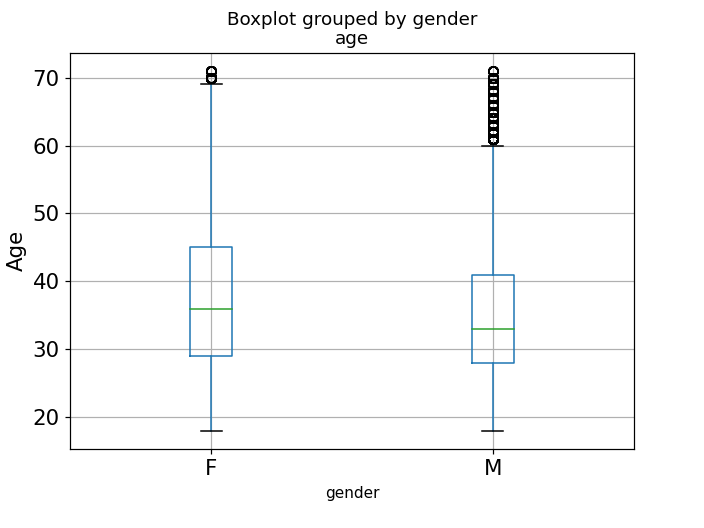

(array([10., 20., 30., 40., 50., 60., 70., 80.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

In [48]:
init_data.boxplot(by='gender', column='age')

plt.ylabel('Age', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

На первый взгляд, может показаться, что средний возраст кредитующихся женщин выше, чем у мужчин. Давайте проверим данную гипотезу методом бутстрапа.

#### Проверка статистической значимости различий в среднем возрасте кредитуемых гендеров

In [49]:
def permutation_test(x:np.array, n_group_1:int, n_group_2:int) -> float:
    """
    Функция возвращает разность средних значений массивов первой и второй групп, которые были получены рандомным разделением 
    исходных индексов массива путем извлечения без возврата.
    
    x - исходный массив с результатами, полученный слиянием массивов результатов для двух разных групп (А, В)
    n_group_1 - длина массива записей наблюдений для группы А
    n_group_2 - длина массива записей наблюдений для группы В
    """
    total_result_len = n_group_1 + n_group_2
    index_group_1 = set(random.sample(range(total_result_len), n_group_1))
    index_group_2 = set(range(total_result_len)) - index_group_1
    return x.loc[index_group_1].mean() - x.loc[index_group_2].mean()

In [347]:
def bootstrap_feature(feature, grouping_feature, data, grouped_data=None, perm_test_number=5000):
    """
    Производит перестановочный тест параметра *feature* двух категорий, находящихся в столбце *grouping_feature*,
    по которым произведена группировка *grouped_data*. 
    Производит сравнение наблюдаемой в датасете разницы средних с бутстраповским распределением, расчитывает p-value,
    строит график бутстраповского распределения разностей средних.
    
    Параметры
    ----------
    feature : str
        Параметр для которого требуется определить статистическую значимость различия средних в двух категориях
        
    grouping_feature : str
        Название столбца в *data*, в котором находится информация о двух категориях, по которым идет сравнение
        
    data : pd.DataFrame
        Исходный массив данных
        
    grouped_data : pd.DataFrame, default: None
        Данные, сгруппированные по признаку *grouping_feature*. Если в *grouping_feature* более двух категорий,
        то можно передать в данный параметр DataFrame, где в качестве индексов будут только две нужные категории
        
    perm_test_number : int, default: 5000
        Количество перестановочных тестов
    
    Возвращает:
    ----------
    Словарь основных расчетных параметров и графика  со следующими ключами:
    
    'pvalue': float
        p-value, рассчитанное на основании перестановочного теста
        
    'graph': matplotlib.figure.Figure
        График бутстраповского распределения и наблюдаемого по данным значения
        
    'observed_diff': : float
        Разница средних в двух категориях
        
    'perm_diffs': pandas.Series
        Массив рассчитанных бутстрапированных разниц средних в двух категориях
        в формате pandas.Series   
    """
    cols = ['age', 'credit_count', 'credit_month',
            'credit_sum', 'monthly_income',
            'overdue_credit_count', 'score_shk']
    
    units = ['years', 'quantity', 'quantity',
             'roubles', 'roubles', 'quantity',
             'difference']
    
    xlabel_names = dict(zip(cols, units)) 
    
    if grouped_data is None:
        grouped_data = data.pivot_table(index=grouping_feature)
    
    g1, g2 = grouped_data.index
    observed_diff = grouped_data.loc[g1, feature] - grouped_data.loc[g2, feature]
    print(f'Наблюдаемое различие между категориями {g1} и {g2} равно {observed_diff:.5f}')
    
    g1_observations = data[data[grouping_feature] == g1][feature].dropna().shape[0]
    g2_observations = data[data[grouping_feature] == g2][feature].dropna().shape[0]
    total_observations = data[(data[grouping_feature] == g1) | (data[grouping_feature] == g2)]\
                            [feature].dropna().reset_index(drop=True)

    assert g1_observations + g2_observations == total_observations.shape[0], 'Длины массивов не совпадают'

    perm_diffs = pd.Series([permutation_test(total_observations, g1_observations, g2_observations)
                  for _ in tqdm(range(perm_test_number))])
    
    fig, ax = plt.subplots(figsize = (8,5))
    ax.hist(perm_diffs, bins=50)
    ax.axvline(observed_diff, color='black')
    ax.text(observed_diff, np.cbrt(perm_test_number), 'Observed\nvalue')
    ax.set_xlabel(xlabel_names[feature])
    ax.set_ylabel('Frequency')
    ax.set_title(f'Bootstrapped difference in mean {feature} for {g1} and {g2}')
    
    p_val_perm = min((perm_diffs < observed_diff).mean(), (perm_diffs > observed_diff).mean())
    print(f'Вероятность обнаружить результаты, обусловленные случайностью и превосходящие \
полученные данные, равна {p_val_perm*100:.5f} %.')
    
    return {'pvalue': p_val_perm,
            'graph': fig,
            'observed_diff': observed_diff,
            'perm_diffs': perm_diffs}

Наблюдаемое различие между категориями F и M равно 2.64943


  0%|          | 0/2000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


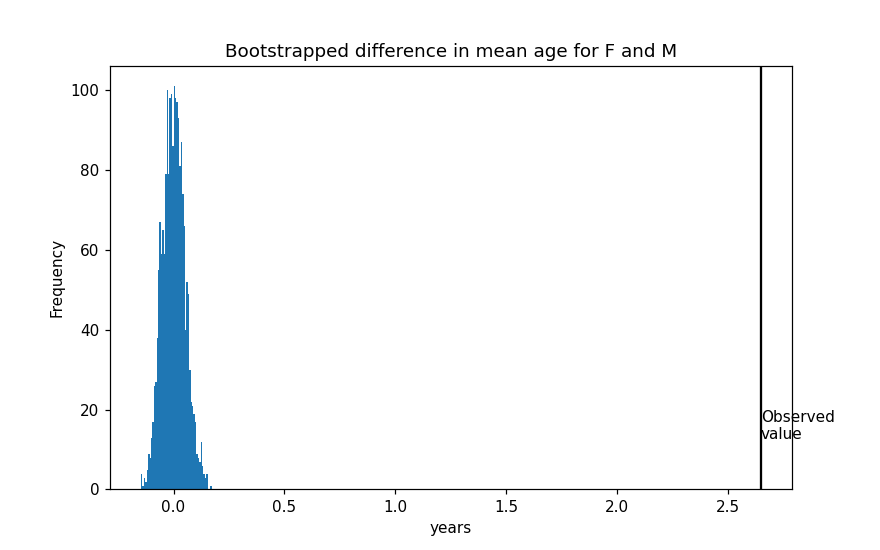

Вероятность обнаружить результаты, обусловленные случайностью и превосходящие полученные данные, равна 0.00000 %.


In [349]:
age_bootstrap_info = bootstrap_feature('age', 'gender', init_data, perm_test_number=2000)

Поскольку наблюдаемое значение не принадлежит бутстрапированной выборке, следовательно, ***нет оснований отвергать гипотезу*** о превосходящем среднем возрасте кредитующихся женщин.

#### Проверка статистической значимости различий количества кредитов от гендера

In [50]:
print(gender_grouped['credit_count'])

gender
F    2.132642
M    2.079737
Name: credit_count, dtype: float64


<IPython.core.display.Javascript object>


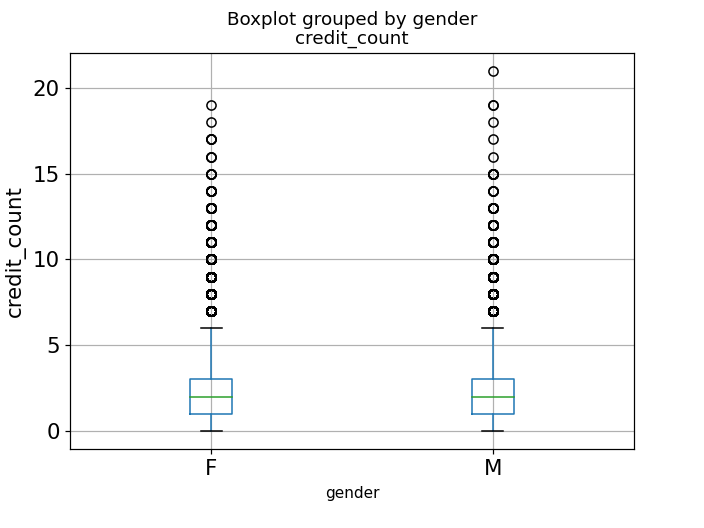

(array([-5.,  0.,  5., 10., 15., 20., 25.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

In [350]:
init_data.boxplot(by='gender', column='credit_count')

plt.ylabel('credit_count', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

Наблюдаемое различие между категориями F и M равно 0.05291


  0%|          | 0/2000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


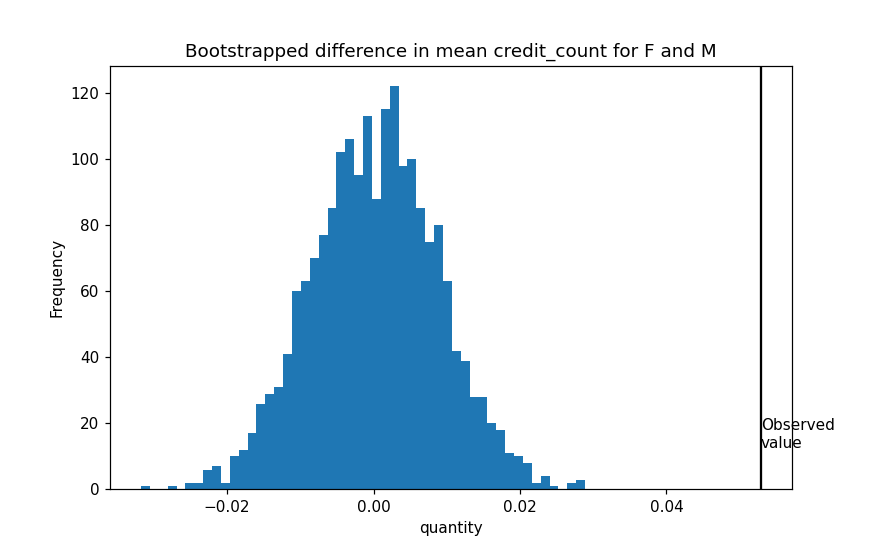

Вероятность обнаружить результаты, обусловленные случайностью и превосходящие полученные данные, равна 0.00000 %.


In [351]:
credit_count_bootstrap_info = bootstrap_feature('credit_count', 'gender', init_data, perm_test_number=2000)

Поскольку наблюдаемое значение разностей среднего количества кредитов не принадлежит бутстрапированной выборке, следовательно, ***нет оснований отвергать гипотезу*** о превосходящем среднем количестве кредитов у кредитующихся женщин.

#### Проверка статистической значимости различий срока кредитования от гендера

In [143]:
gender_grouped

,age,credit_count,credit_month,credit_sum,monthly_income,overdue_credit_count,score_shk
gender,,,,,,,
F,37.770404,2.132642,10.974419,25563.397526,35266.089623,0.045822,0.470975
M,35.120978,2.079737,10.987593,26669.878945,45405.846551,0.046340,0.467850


Наблюдаемое различие между категориями F и M равно -0.01317


  0%|          | 0/2000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


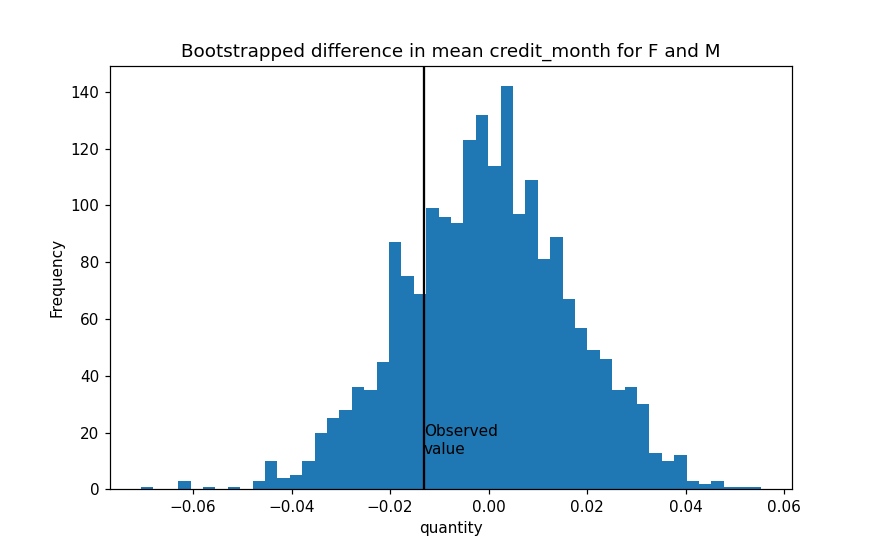

Вероятность обнаружить результаты, обусловленные случайностью и превосходящие полученные данные, равна 21.90000 %.


In [352]:
credit_count_bootstrap_info = bootstrap_feature('credit_month', 'gender', init_data, perm_test_number=2000)

Поскольку наблюдаемое значение разностей среднего срока кредитования принадлежит бутстрапированной выборке, следовательно, ***мы отвергаем гипотезу*** о превосходящем среднем сроке кредитов у кредитующихся мужчин.

#### Проверка статистической значимости различий количества просроченных кредитов от гендера

Наблюдаемое различие между категориями F и M равно -0.00052


  0%|          | 0/2000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


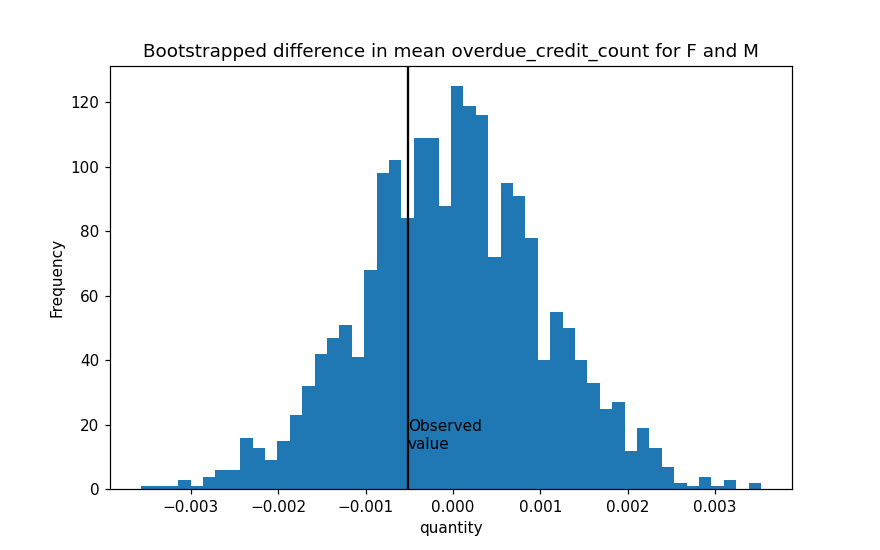

Вероятность обнаружить результаты, обусловленные случайностью и превосходящие полученные данные, равна 30.80000 %.


In [353]:
overdue_credit_count_bootstrap_info = bootstrap_feature('overdue_credit_count', 'gender', init_data, perm_test_number=2000)

Поскольку наблюдаемое значение разностей среднего количества просроченных кредитов принадлежит бутстрапированной выборке, следовательно, ***мы отвергаем гипотезу*** о превосходящем количестве просроченных кредитов у кредитующихся мужчин.

#### Проверка статистической значимости различий внутренней скоринговой оценки от гендера

Наблюдаемое различие между категориями F и M равно 0.00313


  0%|          | 0/2000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


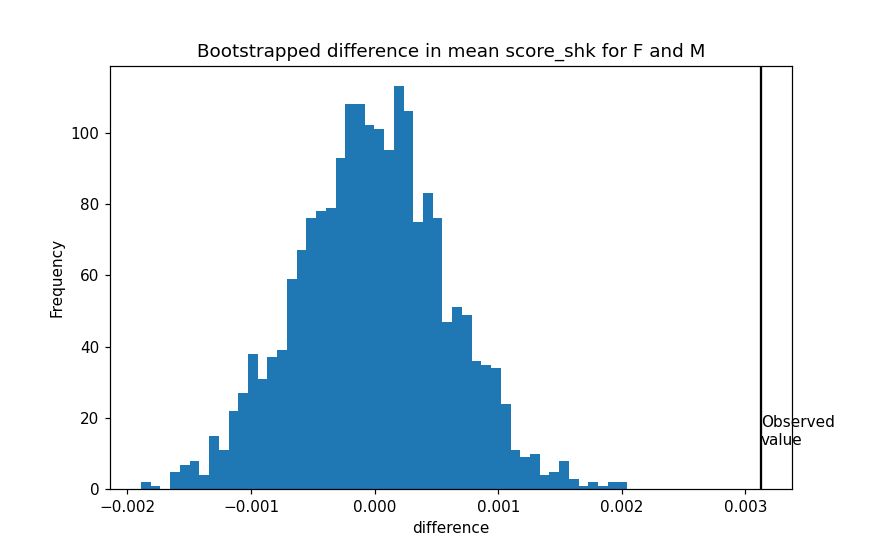

Вероятность обнаружить результаты, обусловленные случайностью и превосходящие полученные данные, равна 0.00000 %.


In [354]:
score_shk_bootstrap_info = bootstrap_feature('score_shk', 'gender', init_data, perm_test_number=2000)

Поскольку наблюдаемое значение разностей средней внутренней скоринговой оценки не принадлежит бутстрапированной выборке, следовательно, ***нет оснований отвергать гипотезу*** о превосходящей средней оценки кредитующихся женщин.

#### Проверка  различий в открытии кредитного счета в банке от гендера

In [53]:
init_data['open_account_flg'] = init_data['open_account_flg'].astype('float')

In [54]:
init_data.groupby('gender').agg({'open_account_flg':np.mean})

,open_account_flg
gender,
F,0.159814
M,0.193555


На основании данных, представленных в датасете, можно заключить, что мужчины открывают больше счетов в банке Тинькофф.

**Итого:** Средний возраст кредитующихся женщин выше, чем у мужчин, однако, и среднее количество кредитов у женщин также превосходит данный показатель для мужской части населения. Данная тенденция, вероятнее всего, связана с более высокой внутренней  скоринговой оценкой, поскольку продолжительность кредитования и количество просроченных кредитов у обоих гендеров одинаковое. Однако, в среднем, мужчины чаще открывают кредитные счета в банке Тинькофф.

### Гипотеза 2

Гипотеза заключается в наличии существенной разницы в количестве кредитов (их больше) у "семейных" людей.

In [55]:
init_data.head()

,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,monthly_income,credit_count,overdue_credit_count,open_account_flg
0,M,NaN,NaN,UMN,59998.00,10,1_6,NaN,GRD,КРАСНОДАРСКИЙ,30000.0,1.0,1.0,0.0
1,F,NaN,MAR,UMN,10889.00,6,1_1,NaN,NaN,МОСКВА,NaN,2.0,0.0,0.0
2,M,32.0,MAR,SPC,10728.00,12,1_1,NaN,NaN,САРАТОВСКАЯ,NaN,5.0,0.0,0.0
3,F,27.0,NaN,SPC,12009.09,12,1_1,NaN,NaN,ВОЛГОГРАДСКАЯ,NaN,2.0,0.0,0.0
4,M,45.0,NaN,SPC,NaN,10,1_1,0.421385,SCH,ЧЕЛЯБИНСКАЯ,NaN,1.0,0.0,0.0


In [56]:
init_data.marital_status.value_counts(dropna=False)

MAR    93954
UNM    52149
DIV    16969
CIV     4196
WID     3475
NaN        3
Name: marital_status, dtype: int64

Поскольку в задаче явно не дана расшифровка сокращений семейного положения, то предположим, что:
1. MAR - это (married) замужем/женат
2. UNM - это (unmarried) не женат/замужем
3. DIV - это (divorced) в разводе
4. CIV - ? может в гражданском браке
5. WID - это (widowed) вдова/вдовец

In [79]:
marstat_gender_grouped = init_data.groupby(['marital_status', 'gender'])

<IPython.core.display.Javascript object>


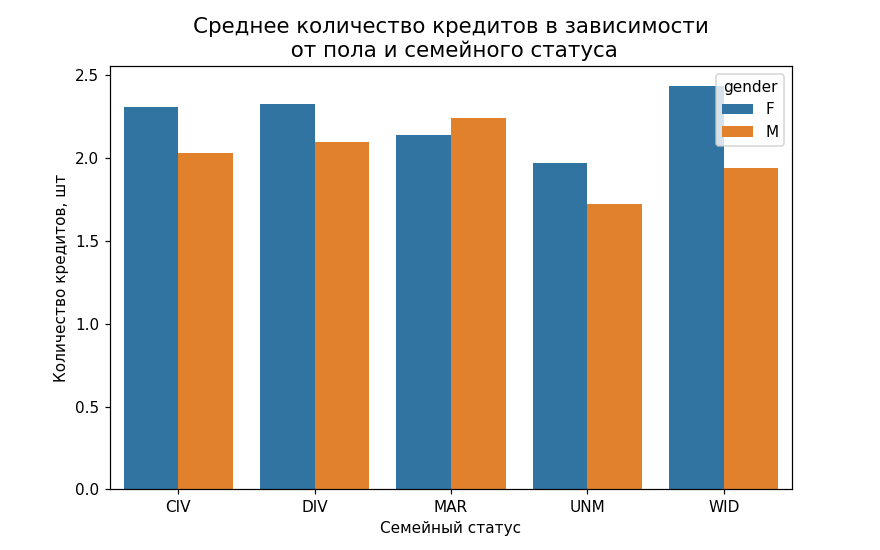

Text(0, 0.5, 'Количество кредитов, шт')

In [78]:
plt.figure(figsize=(8, 5))
ax = sns.barplot(data=marstat_gender_grouped.agg(np.mean).reset_index(), x='marital_status', y='credit_count', hue='gender')

plt.title('Среднее количество кредитов в зависимости\n от пола и семейного статуса', fontsize=14)

plt.xlabel('Семейный статус', fontsize=10)
plt.ylabel('Количество кредитов, шт', fontsize=10)

<IPython.core.display.Javascript object>


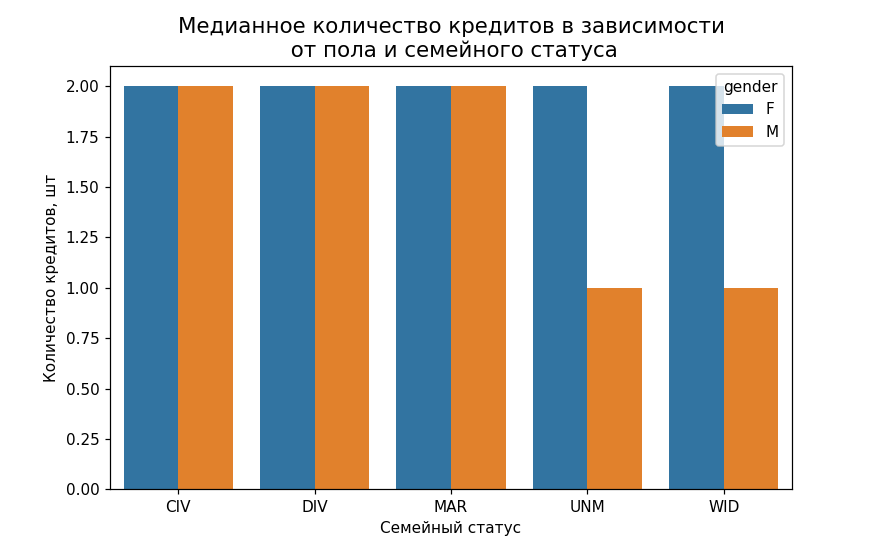

Text(0, 0.5, 'Количество кредитов, шт')

In [82]:
plt.figure(figsize=(8, 5))
ax = sns.barplot(data=marstat_gender_grouped.agg(np.median).reset_index(), x='marital_status', y='credit_count', hue='gender')

plt.title('Медианное количество кредитов в зависимости\n от пола и семейного статуса', fontsize=14)

plt.xlabel('Семейный статус', fontsize=10)
plt.ylabel('Количество кредитов, шт', fontsize=10)

Исходя из данных, отображенных на вышеприведенных графиках, можно заметить, что женская часть населения в среднем имеет больше кредитов, чем мужская, однако, это несправедливо для замужних людей. В случае женатых мужчин среднее количество кредитов превосходит данный показатель для замужних женщин.

Также, можно заметить, что женатые женщины имеют меньше кредитов, чем женщины в разводе, овдовевшие и находящиеся в гражданском браке, однако больше, чем неженатые.

В случае женатых мужчин картина обратная - данная категория мужчин имеет наибольшее количество кредитов среди остальных типов мужского населения.

Однако, медианное значение для всех категорий одинаково (2 кредита), но только не для неженатых и овдовевших мужчин (1 кредит).

Таким образом, наша исходная гипотеза о большем количестве кредитов у "семейных" людей справедлива только для мужчин.

### Гипотеза 3

Гипотеза заключается в том, что молодым одобряют кредиты на меньшие суммы, по сравнению с людьми за 35.

<IPython.core.display.Javascript object>


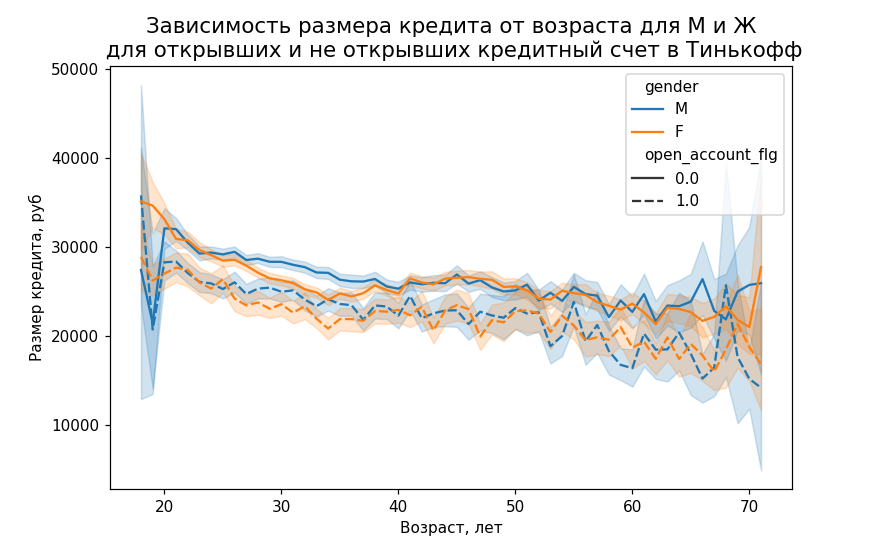

Text(0, 0.5, 'Размер кредита, руб')

In [89]:
plt.figure(figsize=(8, 5))
ax = sns.lineplot(data=init_data, x='age', y='credit_sum', hue='gender', style='open_account_flg')

plt.title('Зависимость размера кредита от возраста для М и Ж\n для открывших и не открывших кредитный счет в Тинькофф',
           fontsize=14)

plt.xlabel('Возраст, лет', fontsize=10)
plt.ylabel('Размер кредита, руб', fontsize=10)

Исходя из полученных данных, можно предположить, что в случае отказа в кредите размер займа был в среднем выше, чем в случае одобрения вне зависимости от возраста клиента.

Касательно исходной гипотезы, то в данном случае зависимость не тривиальная, т.е. изначально, на промежутке от 18 до 35-38 лет наблюдается тенденция ко снижению размера кредита, далее происходит "легкий" отскок на промежутке 40-55 лет (возможно берут кредит для помощи своим детям) с последующим снижением. 

В период после 65 лет сумма кредита имеет большее стандартное отклонение, что, вероятнее всего, связано с увеличением доли кредитов на лечение, либо на потребности, требующие больших средств на удовлетворение.

### Гипотеза 4

Гипотеза заключается в том, что с увеличением возраста доля плохих заемщиков падает.

In [110]:
init_data['bad_borrower'] = init_data['overdue_credit_count'] > 0
bad_borrower_gend_age = init_data.groupby(['gender', 'age']).agg({'bad_borrower':[np.mean, 'count']}).reset_index()
bad_borrower_gend_age['bad_borrower_pct'] = bad_borrower_gend_age.loc[:,('bad_borrower','mean')] * 100
bad_borrower_gend_age

gender   age bad_borrower       bad_borrower_pct
                         mean count                 
0        F  18.0     0.000000    99         0.000000
1        F  19.0     0.004843   413         0.484262
2        F  20.0     0.004386   684         0.438596
3        F  21.0     0.004248  1177         0.424809
4        F  22.0     0.010019  1597         1.001879
5        F  23.0     0.014540  1857         1.453958
6        F  24.0     0.028875  2355         2.887473
7        F  25.0     0.031634  2687         3.163379
8        F  26.0     0.036796  3071         3.679583
9        F  27.0     0.035381  3109         3.538115
10       F  28.0     0.042123  3466         4.212349
11       F  29.0     0.050269  3342         5.026930
12       F  30.0     0.053677  3372         5.367734
13       F  31.0     0.043803  3082         4.380273
14       F  32.0     0.048978  3083         4.897827
15       F  33.0     0.045200  3208         4.519950
16       F  34.0     0.046385  2932         4.638472
17       F  35.0     0.059358  2864         5.935754
18       F  36.0     0.051110  2837         5.111033
19       F  37.0     0.058164  2854         5.816398
20       F  38.0     0.054092  2847         5.409203
21       F  39.0     0.045210  2787         4.520990
22       F  40.0     0.052183  2817         5.218317
23       F  41.0     0.042945  2608         4.294479
24       F  42.0     0.044365  2502         4.436451
25       F  43.0     0.040843  2277         4.084321
26       F  44.0     0.049286  2171         4.928604
27       F  45.0     0.041667  1872         4.166667
28       F  46.0     0.036364  1815         3.636364
29       F  47.0     0.048765  1620         4.876543
30       F  48.0     0.050532  1504         5.053191
31       F  49.0     0.040149  1345         4.014870
32       F  50.0     0.039288  1349         3.928836
33       F  51.0     0.045100  1153         4.509974
34       F  52.0     0.048293  1201         4.829309
35       F  53.0     0.048676  1171         4.867635
36       F  54.0     0.047619  1113         4.761905
37       F  55.0     0.048927  1165         4.892704
38       F  56.0     0.053628   951         5.362776
39       F  57.0     0.047461   906         4.746137
40       F  58.0     0.049200   813         4.920049
41       F  59.0     0.046089   716         4.608939
42       F  60.0     0.043818   639         4.381847
43       F  61.0     0.031196   577         3.119584
44       F  62.0     0.049724   543         4.972376
45       F  63.0     0.042373   472         4.237288
46       F  64.0     0.056098   410         5.609756
47       F  65.0     0.045181   332         4.518072
48       F  66.0     0.019685   254         1.968504
49       F  67.0     0.038911   257         3.891051
50       F  68.0     0.023810   168         2.380952
51       F  69.0     0.031250   128         3.125000
52       F  70.0     0.010000   100         1.000000
53       F  71.0     0.043478    23         4.347826
54       M  18.0     0.000000     7         0.000000
55       M  19.0     0.000000    17         0.000000
56       M  20.0     0.005333   375         0.533333
57       M  21.0     0.005937  1179         0.593723
58       M  22.0     0.008273  1934         0.827301
59       M  23.0     0.017234  2437         1.723430
60       M  24.0     0.022439  3075         2.243902
61       M  25.0     0.034065  3464         3.406467
62       M  26.0     0.038913  3752         3.891258
63       M  27.0     0.042746  3977         4.274579
64       M  28.0     0.046303  4125         4.630303
65       M  29.0     0.051362  4186         5.136168
66       M  30.0     0.053842  3956         5.384226
67       M  31.0     0.047206  3686         4.720564
68       M  32.0     0.047324  3550         4.732394
69       M  33.0     0.050178  3368         5.017815
70       M  34.0     0.054329  2945         5.432937
71       M  35.0     0.062455  2786         6.245513
72       M  36.0     0.047118  2568         4.711838
73       M  37.0     0.051975

<IPython.core.display.Javascript object>


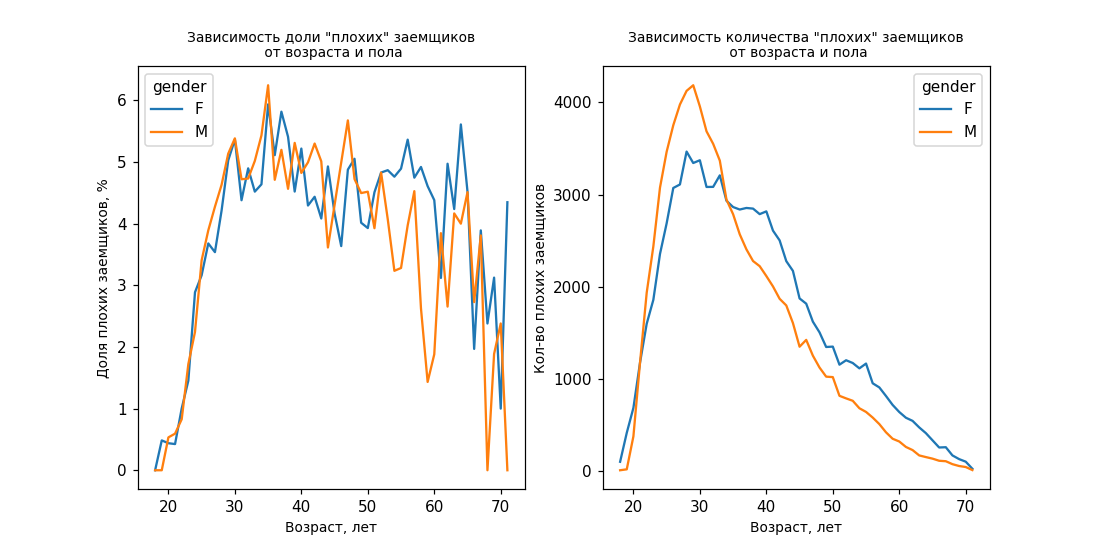

Text(0, 0.5, 'Кол-во плохих заемщиков')

In [173]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(data=bad_borrower_gend_age, x='age', y='bad_borrower_pct', hue='gender', ax=ax[0])
sns.lineplot(data=bad_borrower_gend_age, x='age', y=('bad_borrower','count'), hue='gender', ax=ax[1])

ax[0].set_title('Зависимость доли "плохих" заемщиков\n от возраста и пола',
           fontsize=9)
ax[1].set_title('Зависимость количества "плохих" заемщиков\n от возраста и пола',
           fontsize=9)

ax[0].set_xlabel('Возраст, лет', fontsize=9)
ax[1].set_xlabel('Возраст, лет', fontsize=9)

ax[0].set_ylabel('Доля плохих заемщиков, %', fontsize=9)
ax[1].set_ylabel('Кол-во плохих заемщиков', fontsize=9)

In [111]:
plt.subplots?


При рассмотрении категории "плохих" заемщиков было обнаружено, что в диапазоне возрастов от 20 до 35 лет наблюдается увеличение как числа, так и их доли для обоих полов. В дальнейшем наблюдается нисходящий тренд.

### Гипотеза 5

Гипотеза заключается в том, что сумма кредита пропорциональна зарплате клиента.

In [119]:
init_data.columns

Index(['gender', 'age', 'marital_status', 'job_position', 'credit_sum',
       'credit_month', 'tariff_id', 'score_shk', 'education', 'living_region',
       'monthly_income', 'credit_count', 'overdue_credit_count',
       'open_account_flg', 'bad_borrower'],
      dtype='object')

<IPython.core.display.Javascript object>


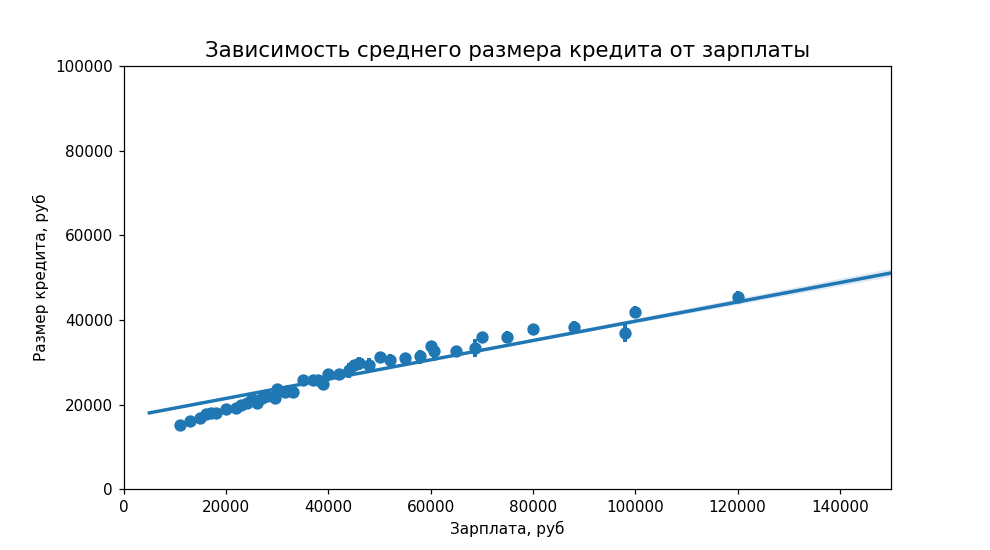

Text(0, 0.5, 'Размер кредита, руб')

In [169]:
plt.figure(figsize=(9,5))
ax=sns.regplot(data=init_data, x='monthly_income', y='credit_sum', x_bins=100)
ax.set_xlim(0, 150000)
ax.set_ylim(0, 100000)

plt.title('Зависимость среднего размера кредита от зарплаты',fontsize=14)

plt.xlabel('Зарплата, руб', fontsize=10)
plt.ylabel('Размер кредита, руб', fontsize=10)

<IPython.core.display.Javascript object>


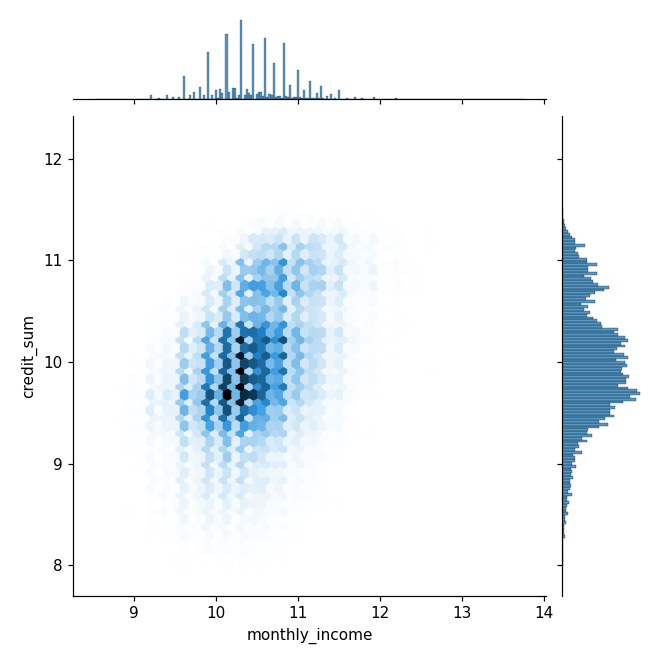

In [171]:
# Поскольку распределение зарплат и сумм кредитов имеют длинные хвосты, решено было логарифмировать данные фичи
ax=sns.jointplot(x=np.log(init_data['monthly_income']), y=np.log(init_data['credit_sum']),kind='hex')


___

Стандартный тест для количественных признаков - это проверка ***корреляции Пирсона***. Однако, предварительно надо проверить условия для этого теста. Если условия соблюдаются, то мы применяем тест. Если условия не соблюдаются, то мы можем либо подогнать данные к нормальному распределению, либо использовать непараметрические тесты. Это правило применяется к любому тесту: мы всегда должны сначала проверить соблюдение условий для применения конкретного теста.

*Когда применяется?*

Корреляция по Пирсону применяется, когда нужно проверить связь между двумя непрерывными переменными.

*Условия применения теста*

1) независимость выборок, 
2) нормальное распределение. 

*Альтернативы, если условия не выполняются* - Непараметрические тесты, корреляция Спирмена, пермутация

*Формула* - См. подробнее [здесь](https://www.pythonfordatascience.org/variance-covariance-correlation/)

*Интерпретация*
 
Если значение больше 0 и меньше 1, то положительная корреляция (уменьшение-уменьшение (минус на минус дает плюс), увеличение-увеличение (плюс на плюс дает плюс)), при 0 связи нет, если меньше 0, то отрицательная (уменьшение-увелиение (минус на плюс дает минус), увеличение-уменьшение (плюс на минус дает минус)). 
 
*Особенности*

Важно, если связь носит нелинейный характер, то возможна ошибочная интерпретация. Чувствителен к выбросам, можно применять робастную корреляцию Пирсона.
Если есть подозрение, что третья переменная влияет на две, у которых смотрим корреляцию, то можно применить частичную корреляцию.
Можно использовать Distance correlation для определения не только линейной, но и нелинейной связи переменных.
Сильно коррелированные переменные можно объединить в одну, например через умножение, деление. Удалять изначальные нельзя. Можно также использовать метод главных компонент. При подозрении на нелинейность связи возможно применение регуляризации, например лассо или гребневой.
 
Независимость выборок понятие оценочное, поэтому определяется исследователем. Нормальное распределение можно проверить специальными методами: визуально, расчетами.

---

Изначально проверим вид распределение для зарплат и размеров кредитов.

<IPython.core.display.Javascript object>


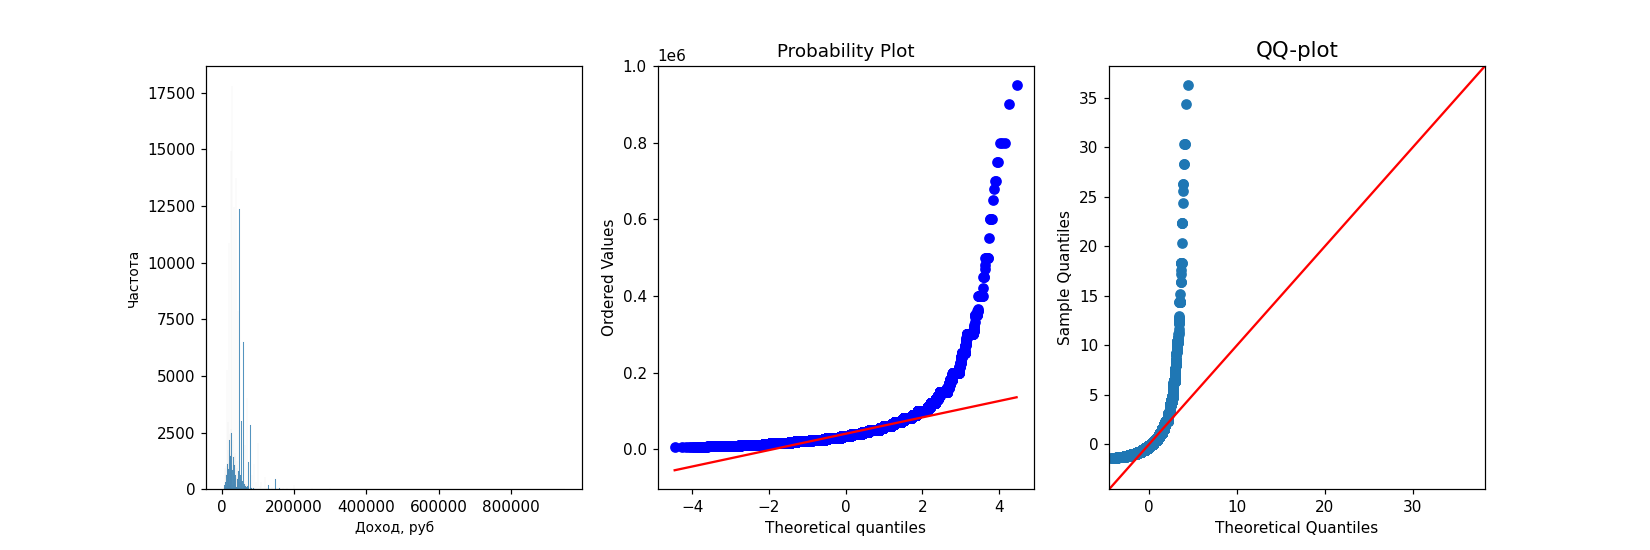

Text(0.5, 1.0, 'QQ-plot')

In [200]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

sns.histplot(init_data['monthly_income'].dropna(), ax=ax[0])
probplot(init_data['monthly_income'].dropna(), plot=ax[1])
sm.qqplot(init_data['monthly_income'].dropna(), norm, fit=True, line='45', ax=ax[2])

ax[0].set_xlabel('Доход, руб', fontsize=9)
ax[0].set_ylabel('Частота', fontsize=9)

ax[2].set_title('QQ-plot', fontsize=14)

Исходя из видов графиков, можно заключить, что данные <ins>не распределены по нормальному закону</ins>, следовательно, необходимо преобразовать их к такому виду. Можно предположить, что доходы распределены по степенному закону распределения, следовательно можно попробовать логарифмировать данные.

Для определения статистики, описывающей нормальность распределения применим тест Шапиро.
См. подробнее [здесь](https://pingouin-stats.org/generated/pingouin.normality.html?highlight=shapiro)

In [239]:
shapiro(init_data['monthly_income'].dropna().sample(300))

ShapiroResult(statistic=0.8958572745323181, pvalue=1.7237815721268118e-13)

Вычисляем интересующую нас статистику Шапиро и проверям нулевую гипотезу. Здесь нулевая гипотеза: данные распределены нормально. Так как pvalue < 0.05 мы отвергаем нулевую гипотезу и принимаем альтернативную, то есть мы отвергаем гипотезу, что данные распределены нормально, и *принимаем гипотезу, что данные не распределены нормально*. Такой результат называется статистически значимым.

Возможно применение и иных методов: тест на нормальность D'Agostino-Pearson, тест Колмагорова-Смирнова.

In [215]:
for_pearson = init_data[['monthly_income', 'credit_sum']].copy()
for_pearson.dropna(inplace=True)

<IPython.core.display.Javascript object>


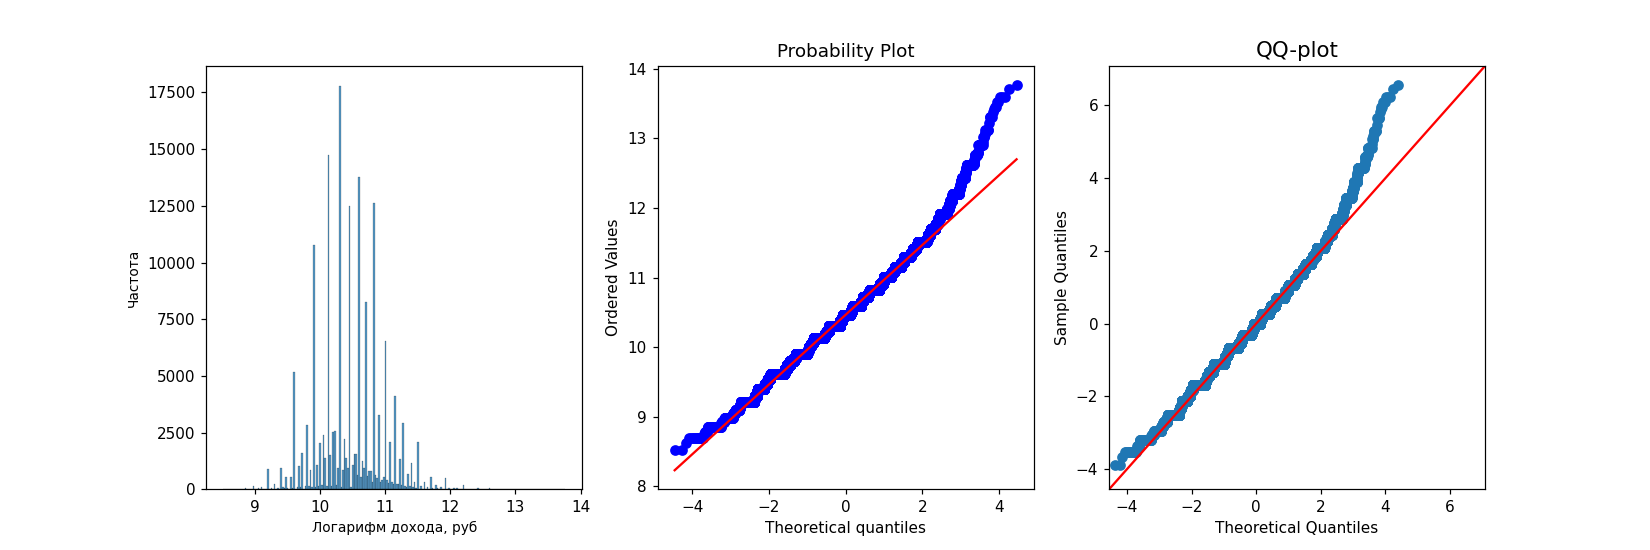

Text(0.5, 1.0, 'QQ-plot')

In [216]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

log_data = np.log(for_pearson['monthly_income'])

sns.histplot(log_data, ax=ax[0])
probplot(log_data, plot=ax[1])
sm.qqplot(log_data, norm, fit=True, line='45', ax=ax[2])

ax[0].set_xlabel('Логарифм дохода, руб', fontsize=9)
ax[0].set_ylabel('Частота', fontsize=9)

ax[2].set_title('QQ-plot', fontsize=14)

In [241]:
shapiro(log_data.sample(500))
# Cтатистический тест говорит, что даже после логарифмирования данные не распределены нормально.

ShapiroResult(statistic=0.9878196716308594, pvalue=0.0003491464303806424)

После применения логарифма к нашим данным их распределение стало больше похоже на нормальное, однако все еще остались "черные лебеди", т.е. длинный хвост - люди с очень большими зарплатами. Можно попробовать преобразовать данные методом [Бокса-Кокса](http://www.machinelearning.ru/wiki/index.php?title=Метод_Бокса-Кокса).

$$y = \{ y_1, \ldots, y_n \}, \quad y_i > 0, \quad i = 1,\ldots,n"$$

$$y_i^{\lambda} = \begin{cases}\frac{y_i^\lambda-1}{\lambda};\text{if } \lambda \neq 0,\\ \log{(y_i)}; \text{if } \lambda = 0.\end{cases}"$$ 

<IPython.core.display.Javascript object>


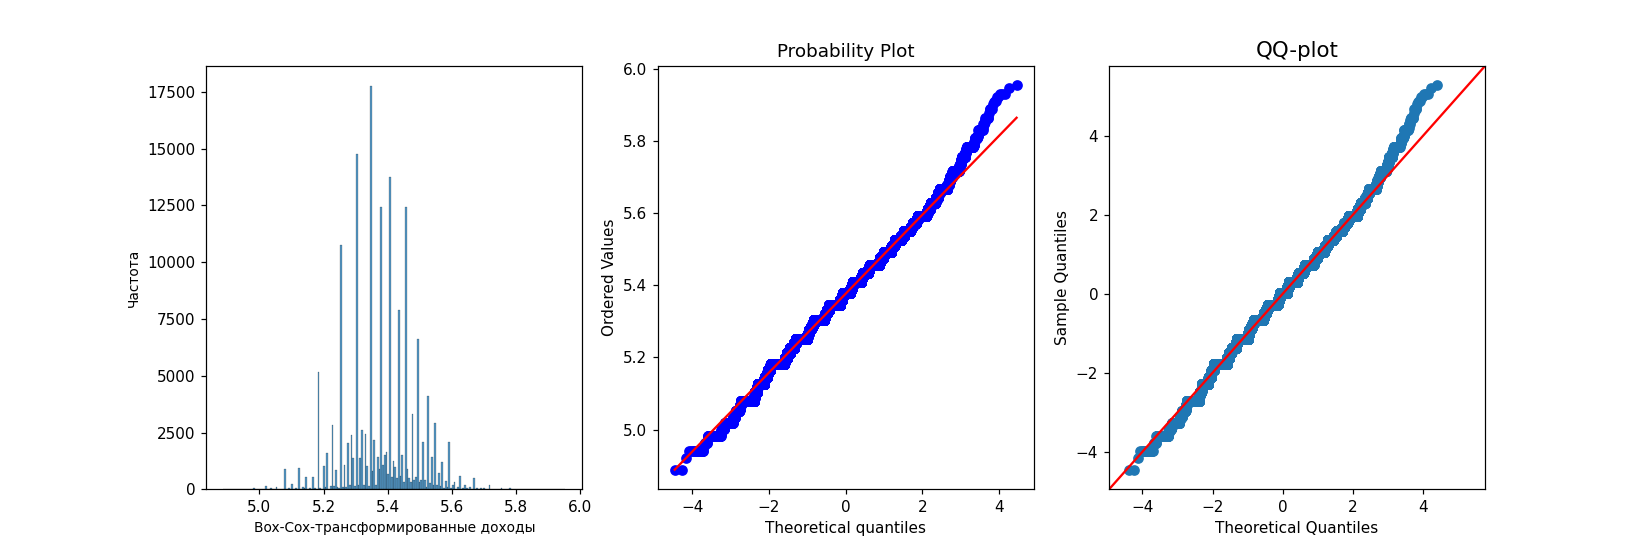

Text(0.5, 1.0, 'QQ-plot')

In [217]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

boxcox_income_data, _ = boxcox(for_pearson['monthly_income'])

sns.histplot(boxcox_income_data, ax=ax[0])
probplot(boxcox_income_data, plot=ax[1])
sm.qqplot(boxcox_income_data, norm, fit=True, line='45', ax=ax[2])

ax[0].set_xlabel('Box-Cox-трансформированные доходы', fontsize=9)
ax[0].set_ylabel('Частота', fontsize=9)

ax[2].set_title('QQ-plot', fontsize=14)

In [242]:
shapiro(boxcox_income_data[:500])

ShapiroResult(statistic=0.991078794002533, pvalue=0.004124481230974197)

Преобразование Бокса-Кокса позволило получить распределение более близкое к нормальному, нежели простое логарифмирование.

Повторим ту же операцию и для сумм кредитов `credit_sum`.

<IPython.core.display.Javascript object>


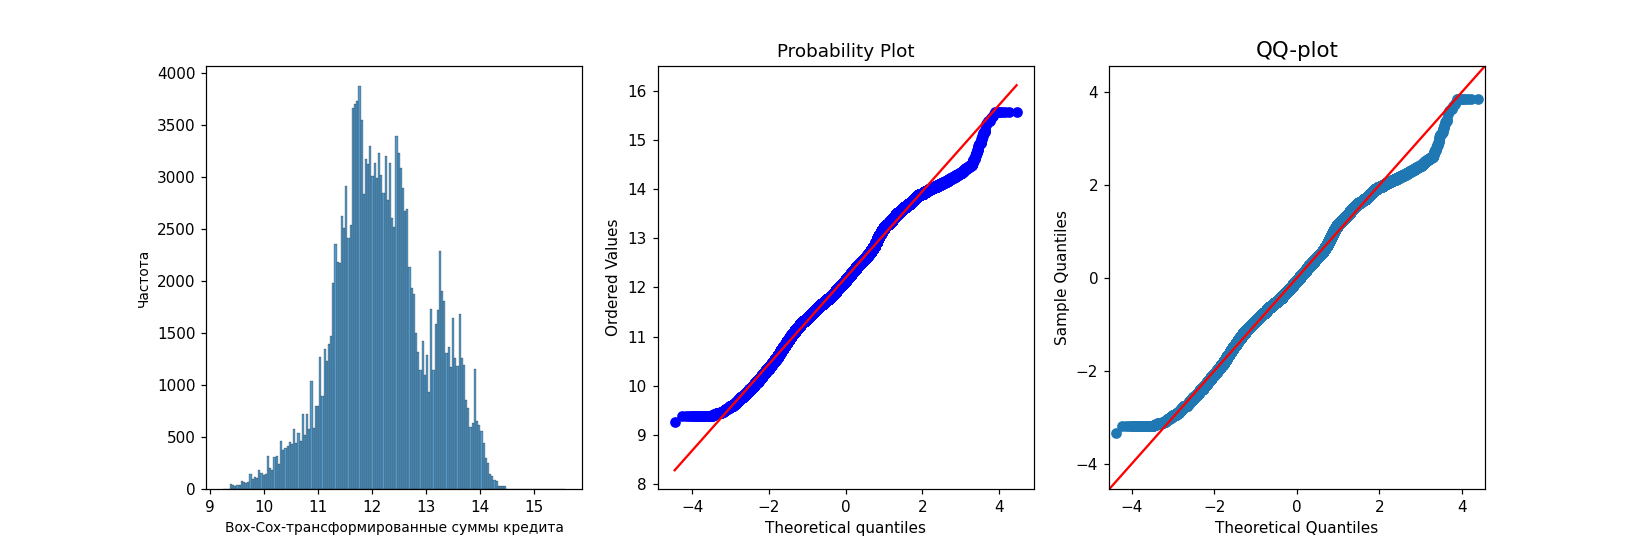

Text(0.5, 1.0, 'QQ-plot')

In [218]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

boxcox_credit_data, _ = boxcox(for_pearson['credit_sum'])

sns.histplot(boxcox_credit_data, ax=ax[0])
probplot(boxcox_credit_data, plot=ax[1])
sm.qqplot(boxcox_credit_data, norm, fit=True, line='45', ax=ax[2])

ax[0].set_xlabel('Box-Cox-трансформированные суммы кредита', fontsize=9)
ax[0].set_ylabel('Частота', fontsize=9)

ax[2].set_title('QQ-plot', fontsize=14)

In [243]:
shapiro(boxcox_credit_data[:500])

ShapiroResult(statistic=0.9841232299804688, pvalue=2.82043511106167e-05)

In [220]:
pirs_coeff_wo_transform = np.corrcoef(for_pearson['monthly_income'].values,
                                      for_pearson['credit_sum'].values)

print(f'Коэффициент Пирсона для суммы кредита и месячной зарплаты без предварительных \
преобразований данных: {pirs_coeff_wo_transform[0][1]:.4f}')

Коэффициент Пирсона для суммы кредита и месячной зарплаты без предварительных преобразований данных: 0.3515


In [208]:
boxcox_income_data

array([5.34546443, 5.34546443, 5.32994436, ..., 5.40852906, 5.35278623,
       5.40852906])

In [221]:
pirs_coeff_w_transform = np.corrcoef(boxcox_income_data, boxcox_credit_data)

print(f'Коэффициент Пирсона для суммы кредита и месячной зарплаты \
преобразованием Бокса-Кокса: {pirs_coeff_w_transform[0][1]:.4f}')

Коэффициент Пирсона для суммы кредита и месячной зарплаты преобразованием Бокса-Кокса: 0.3767


**Итого:** При исследовании данной гипотезы было установлено, что два данных параметра имеют слабую линейную связь, средний размер кредита имеет тенденцию расти с увеличением зарплаты клиента, однако, ввиду слабой корреляции данная взаимосвязь не имеет большой силы.

### Гипотеза 6

Гипотеза заключается в том, что уровень образования зависит от возраста.

In [177]:
init_data.education.unique()

array(['GRD', nan, 'SCH', 'UGR', 'PGR', 'ACD'], dtype=object)

Поскольку в задаче явно не дана расшифровка сокращений уровней образования, то предположим, что:
1. SCH - школьное образование
2. GRD - законченное высшее образование
3. UGR - студент
4. PGR - аспирант
5. ACD - ассоциированная степень колледжа 

<IPython.core.display.Javascript object>


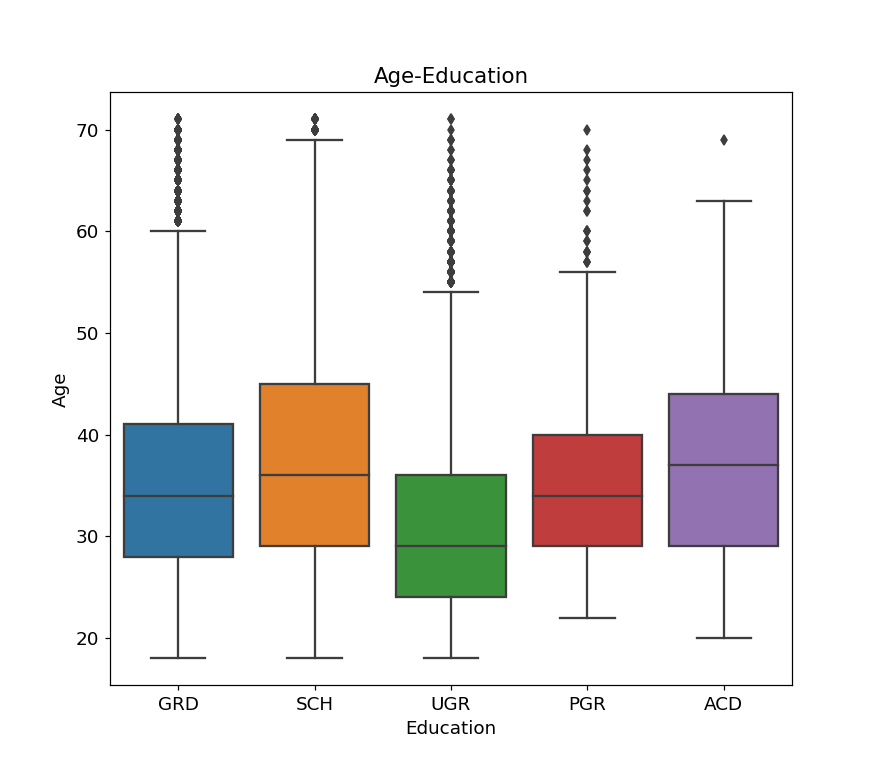

In [175]:
plt.figure(figsize=(8, 7))

sns.boxplot(x='education', y='age', data=init_data)

plt.title('Age-Education', fontsize=14)
plt.ylabel('Age', fontsize=12)
plt.xlabel('Education', fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

___

Для определения различий в среднем возрасте от типа образования можно провести ***дисперсионный анализ***.

Мы проведем тест ANOVA, который также называется дисперсионным анализом.

**Общие условия применения теста ANOVA**

1. выборки независимые; 
2. зависимая переменная нормально распределена; 
3. соблюдается равенство дисперсий.

<ins>I. Дисперсионный анализ однофакторный</ins>

*Когда применяется?*

Проверка средних значений определенной переменной в двух и более группах. Тест проверяет общую разницу между переменными в модели, то есть что по крайней мере одна из групп статистически значимо отличается от других. Однако, если ANOVA значима, нельзя сказать, какие группы отличаются. Чтобы определить, какие группы отличаются друг от друга, необходимо провести плановые или послеплановые сравнения. Например, можно применить апостериорный тест Шеффа для отбора групп.

*Условия применения теста*

1. зависимая переменная – непрерывная, факторы – дихотомические или категориальные. Если некоторые переменные являются категориальными, а другие непрерывными, то анализ называется анализом ковариации (ANCOVA, см. ниже); 
2. каждое значение зависимой переменной не должно зависеть от других ее значений; 
3. нормальное распределение зависимой переменной. Для данного теста предположение о нормальности распределения проверяется на остатках; 
4. однородность дисперсии.

*Альтернативы, если условия не выполняются* - Непараметрический [тест Крускела-Уоллиса](https://en.wikipedia.org/wiki/Kruskal-Wallis_one-way_analysis_of_variance)

*Формула* - См. подробнее [здесь](https://www.pythonfordatascience.org/anova-python/)

*Интерпретация* - См. подробнее [здесь](https://www.pythonfordatascience.org/anova-python/)

*Особенности*

При проведении ANOVA с несколькими факторами, все факторы должны быть проверены на взаимодействие, прежде чем рассматривать их индивидуальные основные эффекты. Если взаимодействие между переменными несущественно, то надо удалить переменные из взаимодействия и провести анализ снова. 


<ins>II. Дисперсионный анализ. Многофакторный<ins>

*Когда применяется?* - Если есть 2 и более фактора.

*Условия применения теста* - Как в однофакторном

*Особенности* - Нулевая гипотеза: нет разницы для зависимой переменной от фактора (взаимодействия факторов)


<ins>III. ANCOVA<ins>

*Когда применяется?* - Если один из факторов – непрерывная переменная.

*Условия применения теста* 

Как обычная ANOVA плюс:
- независимость ковариант и эффектов фактора. Проверяется по ANOVA; 
- однородность регрессионных наклонов определяется по графику.

В данном случае воспользуемся _однофакторным дисперсионным анализом_.
Для начала проверим вид распределения возрастов в разных категориях уровней образования. Мы также знаем, что выборки из разных подгрупп независимы.

In [369]:
rus_education = dict(zip(init_data.education.dropna().unique(),
                         ['высшее образование', 'школьное образование',
                          'студент', 'аспирант',
                          'ассоциированная степень колледжа']))

In [254]:
education_categories = init_data.education.dropna().unique()

In [372]:
education_age_names = {(rus_education[educ_type]):init_data[init_data.education == educ_type].age.dropna()
                       for educ_type in education_categories}

<IPython.core.display.Javascript object>


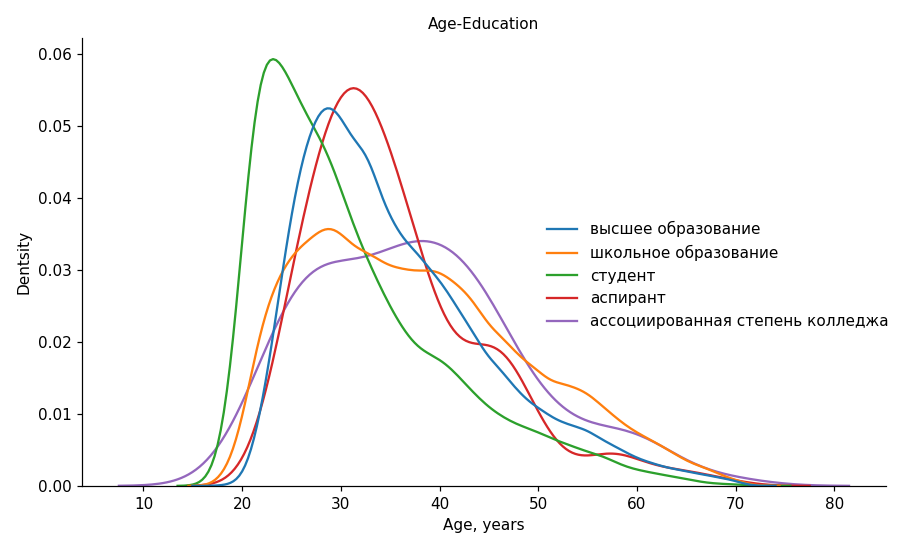

In [373]:
sns.displot(education_age_names,
            kind="kde",
            common_norm=False)

plt.title('Age-Education', fontsize=10)
plt.xlabel('Age, years', fontsize=10)
plt.ylabel('Dentsity', fontsize=10)
plt.tight_layout()

Поскольку распределения возрастов для людей с различным образованием не подчиняются нормальному закону, следовательно, не выполняется условие для применения параметрического теста (ANOVA). Воспользуемся непараметрическим тестом Крускела-Уоллиса.

In [290]:
ages = [tup[1].values for tup in education_age_names.items()]

In [291]:
H_statistics, kruskal_pval = kruskal(ages[0], ages[1], ages[2], ages[3], ages[4])

In [294]:
print(kruskal_pval)

0.0


Поскольку pvalue для наших данных практически нулевое, что эквивалентно вероятности обнаружить подобные данные при отсутствии различий в возрастах, следовательно, **мы отвергаем нулевую гипотезу** об отсутствии разницы между группами.

### Гипотеза 7

Гипотеза заключается в том, что люди с высшим образованием чаще являются "хорошими" заемщиками (имеют меньше просроченных кредитов).

In [296]:
init_data.columns

Index(['gender', 'age', 'marital_status', 'job_position', 'credit_sum',
       'credit_month', 'tariff_id', 'score_shk', 'education', 'living_region',
       'monthly_income', 'credit_count', 'overdue_credit_count',
       'open_account_flg', 'bad_borrower'],
      dtype='object')

Поскольку в задаче явно не дана расшифровка сокращений уровней образования, то предположим, что:
1. SCH - школьное образование
2. GRD - законченное высшее образование
3. UGR - студент
4. PGR - аспирант
5. ACD - ассоциированная степень колледжа 

In [389]:
education_overdue = init_data.groupby(['education']).agg({'overdue_credit_count':'mean'})\
                                                    .sort_values(by='overdue_credit_count')
                                                    
education_overdue.rename(index=rus_education)

,overdue_credit_count
education,
студент,0.041757
школьное образование,0.041816
высшее образование,0.051442
ассоциированная степень колледжа,0.057143
аспирант,0.073801


По величине среднего количества просроченных кредитов, можно сказать, что образованные люди не имеют минимальное значение данного показателя. Студенты и люди, закончившие школу зарекомендовали себя как лица, не склонные к невыполнению обязательств.

Однако, нам необходимо проверить, является ли данное различие статистически значимым. Для этого воспользуемся построением бутстрапированой выборки для сравнения студентов и людей с высшим образованием.

Наблюдаемое различие между категориями GRD и UGR равно 0.00968


  0%|          | 0/2000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


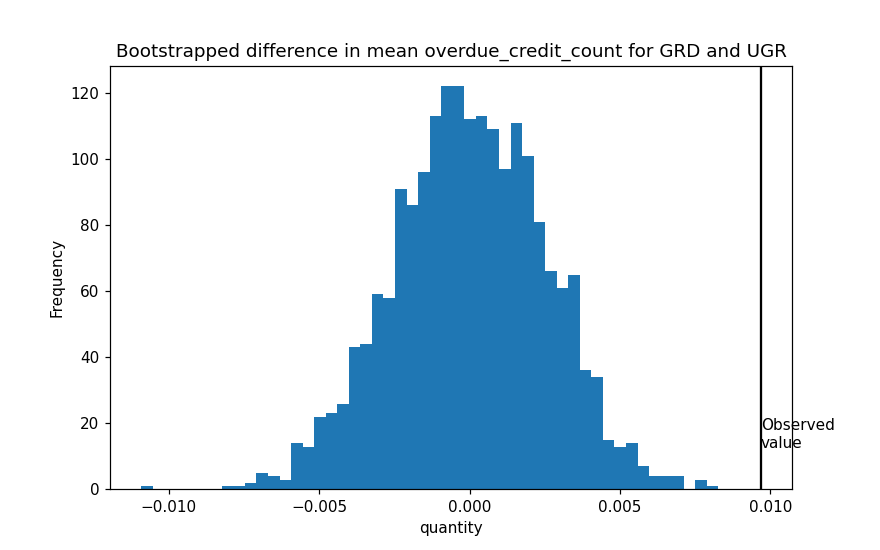

Вероятность обнаружить результаты, обусловленные случайностью и превосходящие полученные данные, равна 0.00000 %.


In [390]:
education_overdue_bootstrap = bootstrap_feature('overdue_credit_count', 'education', init_data,
                                                grouped_data=education_overdue.loc[['GRD','UGR'], :],
                                                perm_test_number=2000)

Таким образом, действительно, студенты менее склонны к просрочке выплат по кредитам.

### Гипотеза 8

Гипотеза заключается в том, что существуют различия в распределении месячного заработка и уровня образования.

In [369]:
rus_education = dict(zip(init_data.education.dropna().unique(),
                         ['высшее образование', 'школьное образование',
                          'студент', 'аспирант',
                          'ассоциированная степень колледжа']))

In [370]:
education_income = {(rus_education[educ_type]):init_data[(init_data.education == educ_type) &
                                                         (init_data.monthly_income < 200000)]\
                                                        .monthly_income.dropna()
                       for educ_type in education_categories}

<IPython.core.display.Javascript object>


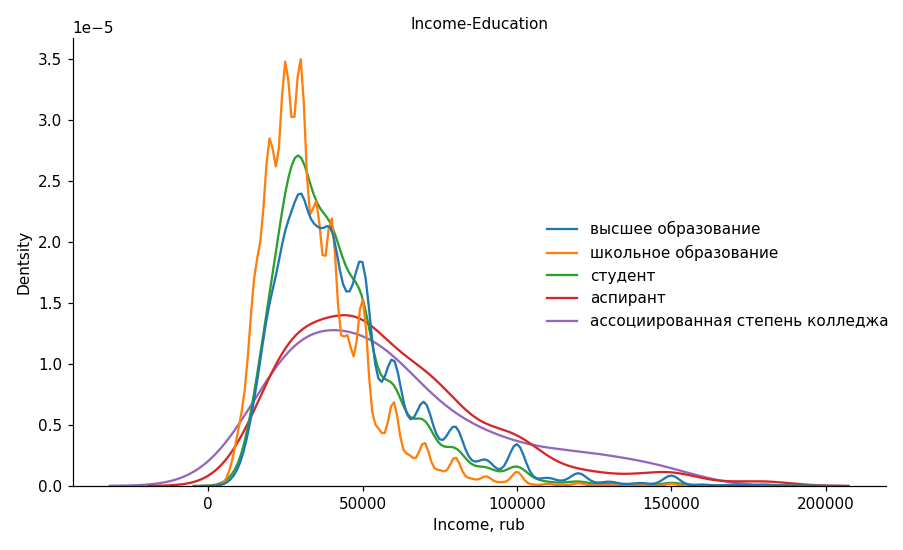

In [371]:
sns.displot(education_income,
            kind="kde",
            common_norm=False)

plt.title('Income-Education', fontsize=10)
plt.xlabel('Income, rub', fontsize=10)
plt.ylabel('Dentsity', fontsize=10)
plt.tight_layout()

In [392]:
education_income = init_data.groupby(['education'])\
                    .agg({'monthly_income':'mean'})\
                    .sort_values(by='monthly_income')

education_income.rename(index=rus_education)

,monthly_income
education,
школьное образование,34553.307009
студент,42278.673675
высшее образование,46376.339119
аспирант,61574.315044
ассоциированная степень колледжа,65735.514019


Исходя из распределения зарплат по различным уровням образования и их средним значениям, можно предположить, что люди со степенью колледжа имеют наивысшую зарплату. Однако, необходимо проверить стат. значимость данного наблюдения. Проведем бутстрап-тест с категорией "аспирант".

Наблюдаемое различие между категориями ACD и PGR равно 4161.19897


  0%|          | 0/2000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


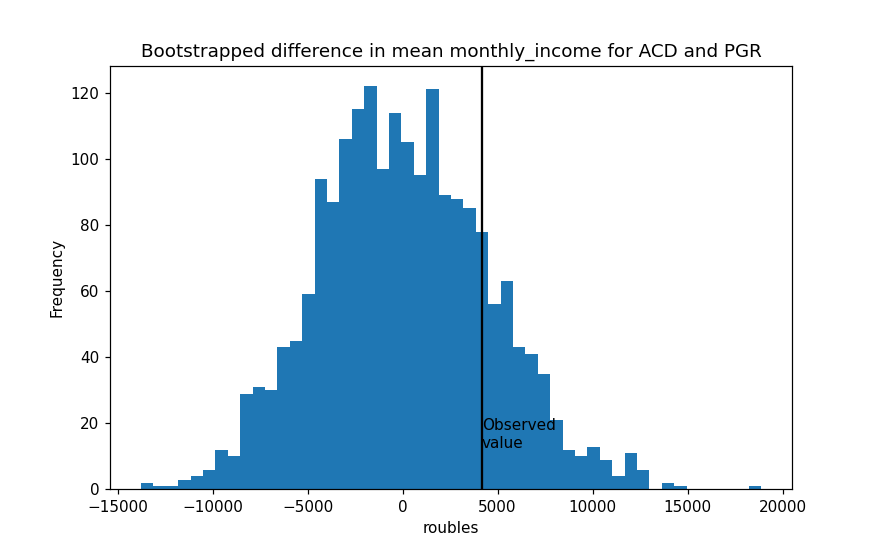

Вероятность обнаружить результаты, обусловленные случайностью и превосходящие полученные данные, равна 18.30000 %.


In [380]:
education_overdue_bootstrap = bootstrap_feature('monthly_income', 'education', init_data,
                                                grouped_data=education_income.loc[['ACD', 'PGR'],:],
                                                perm_test_number=2000)

Перестановочный тест показал, что люди с образованием колледжа и аспирантуры не имеют значимой разницы в средних зарплатах. Сравним их зарплату со следующей категорией - люди с высшим образованием.

Наблюдаемое различие между категориями ACD и GRD равно 19359.17490


  0%|          | 0/2000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


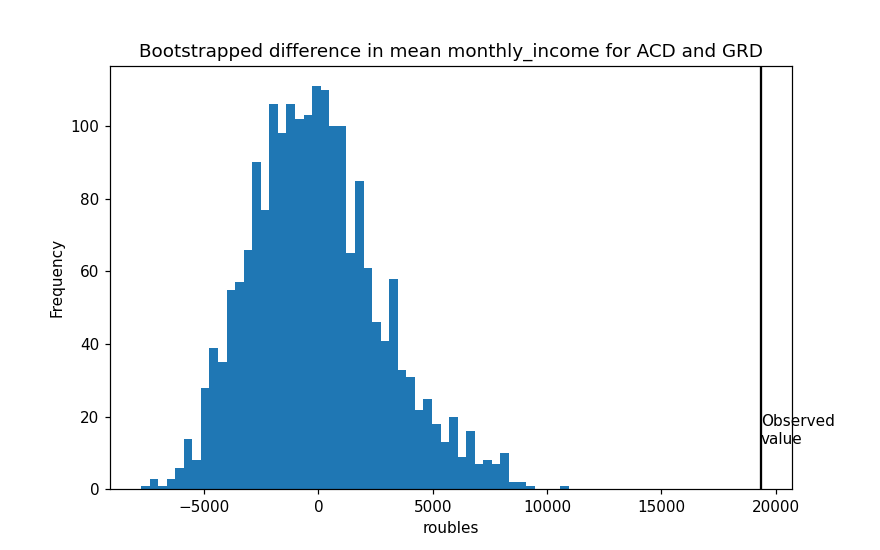

Вероятность обнаружить результаты, обусловленные случайностью и превосходящие полученные данные, равна 0.00000 %.


In [381]:
education_overdue_bootstrap = bootstrap_feature('monthly_income', 'education', init_data,
                                                grouped_data=education_income.loc[['ACD', 'GRD'],:],
                                                perm_test_number=2000)

Перестановочный тест показал, что люди с образованием колледжа и аспирантуры в среднем имеют зарплату выше, чем люди с высшим образованием.

### Гипотеза 9

Гипотеза заключается в том, что количество кредитов у клиентов увеличивается с ростом заработной платы.